# Introduction to Python  

## Natural Language Processing - Exploratory Data Analysis (EDA)

In [1]:
!pip install -U -q pip nltk gensim wordcloud textract textstat textblob spacy pyldavis goose3 numpy openpyxl python-levenshtein openpyxl

#import pip
#pip.main(['install','nltk'])
#pip.main(['install','python-levenshtein'])
#pip.main(['install','-U', 'spacy'])

In [2]:
import os
import time
import codecs
import string
import re
from collections import Counter
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import urllib
import requests
from bs4 import BeautifulSoup
import networkx as nx
import gensim

import nltk
from wordcloud import WordCloud
import textract
from goose3 import Goose
import textblob
from textblob import TextBlob
from textblob import Word

import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import textstat

from IPython.core.display import Image
%matplotlib inline

2021-12-10 07:40:54.989711: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-10 07:40:54.989756: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 1 - Reading and converting text from files:

Specifying the path to the files

In [3]:
datapath = "../Data/"
outputs = "../Data/"
corpuspath = os.path.join(datapath, 'Texts')

Examining files and folders

In [4]:
onlydirs = [f for f in os.listdir(corpuspath) if os.path.isdir(os.path.join(corpuspath,f)) and not f.startswith('.')]
onlydirs

['austen-brontë',
 'french-tragedies-and-comedies',
 'hugo-les-misérables-split',
 'austen-brontë-split',
 'french-tragedy-split',
 'french-tragedy',
 'french-plays',
 'outputs',
 'hugo-les-misérables-original',
 'french-tragedies-and-comedies-split',
 'doccluster',
 'Gutenberg',
 'hugo-les-misérables',
 'stopwords',
 'british-fiction-corpus']

In [5]:
onlyfiles = [f for f in os.listdir(corpuspath) if os.path.isfile(os.path.join(corpuspath,f)) and not f.startswith('.')]
onlyfiles.sort()
onlyfiles

['ARTIGOS-RBE-COM-RESUMO.xlsx',
 'AldousHuxley_bravenewworld.pdf',
 'MarcelProust_EmBuscadoTempoPerdido.pdf',
 'Possibly_Misclassified_Cables_Review.xlsx',
 'RobertFrost_Poetry.pdf',
 'abcnews-date-text.csv']

In [6]:
print('Files in the folder:')
for i, w in enumerate(onlyfiles[0:]):
    print(i+1, '--' ,w)

Files in the folder:
1 -- ARTIGOS-RBE-COM-RESUMO.xlsx
2 -- AldousHuxley_bravenewworld.pdf
3 -- MarcelProust_EmBuscadoTempoPerdido.pdf
4 -- Possibly_Misclassified_Cables_Review.xlsx
5 -- RobertFrost_Poetry.pdf
6 -- abcnews-date-text.csv


#### 1.1 - reading text from CSV file

In [7]:
df = pd.read_excel(os.path.join(corpuspath, 'Possibly_Misclassified_Cables_Review.xlsx'))
df.head()

,id,link to orig. doc,Prob_Classified,Prob_Unclassified,Odds,date,origclass,subject
0,1975BANGKO06331,NaN,0.499997,0.500003,0.999987,1975-04-14,CONFIDENTIAL,gkr pl 480 rice in pipeline
1,1976MOSCOW15759,NaN,0.499995,0.500005,0.999980,1976-10-06,CONFIDENTIAL,oecd east-west initiative suggested addition
2,1974BOGOTA01772,NaN,0.499951,0.500049,0.999804,1974-02-28,CONFIDENTIAL,dea special agent positions
3,1975STATE034056,NaN,0.499901,0.500099,0.999605,1975-02-14,CONFIDENTIAL,homeporting destroyer tender in naples
4,1973STATE241960,NaN,0.499896,0.500104,0.999585,1973-12-11,CONFIDENTIAL,president ceausescu visit


In [8]:
df.columns

Index(['id', 'link to orig. doc', 'Prob_Classified', 'Prob_Unclassified',
       'Odds', 'date', 'origclass', 'subject'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16927 entries, 0 to 16926
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 16927 non-null  object        
 1   link to orig. doc  0 non-null      float64       
 2   Prob_Classified    16927 non-null  float64       
 3   Prob_Unclassified  16927 non-null  float64       
 4   Odds               16927 non-null  float64       
 5   date               16927 non-null  datetime64[ns]
 6   origclass          16927 non-null  object        
 7   subject            16920 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 1.0+ MB


Dropping the rows which are empty

In [10]:
df.dropna(axis='rows', subset=["subject"], inplace=True)

Adding a space at the end of each text and concatenating the texts

In [11]:
df['subject'] += " "

In [12]:
texts = df['subject'].sum()
texts[0:1000]

'gkr pl 480 rice in pipeline oecd east-west initiative suggested addition dea special agent positions homeporting destroyer tender in naples president ceausescu visit opec price decision letter from president carter to president eanes press guidance for npw visit orit boycott pinochet to address labor rally visit of belgian foreign minister to rwanda penney throws in towel srv participation in 20th session escap committee on trade changes in honduran economic leadership vietnamese refugees in thailand tarapur us-ussr housing agreement pre-departure briefing for u.s executive secretary 10.00 civair klm frequencies nkomo-callaghan meeting british hicom informs us that nkomo will depart lusaka night of july 26 for london will meet owens-illinois case annual congressional report on security assistance planned study in u.s by large group of libyans sponsored by libyan atomic energy commission demirel comments on cyprus los resumed seventh session the continental shelf international steel ag

Loading NLTK library and stopwords corpus

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package stopwords to /home/renato/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/renato/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/renato/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/renato/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /home/renato/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [14]:
stop_pt = nltk.corpus.stopwords.words('portuguese')
stop_en = nltk.corpus.stopwords.words('english')
stop_de = nltk.corpus.stopwords.words('german')
stop_en.extend(['-','', '”'])

In [15]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
list_words = texts.split()
list_words = [l.strip().lower() for l in list_words]
list_words = [l.strip(string.punctuation) for l in list_words]
list_words = [l for l in list_words if l not in stop_en]
list_words[0:20]

['gkr',
 'pl',
 '480',
 'rice',
 'pipeline',
 'oecd',
 'east-west',
 'initiative',
 'suggested',
 'addition',
 'dea',
 'special',
 'agent',
 'positions',
 'homeporting',
 'destroyer',
 'tender',
 'naples',
 'president',
 'ceausescu']

In [17]:
# Counter object from https://docs.python.org/3/library/collections.html
from collections import Counter

freqdist = Counter(list_words)

In [18]:
freqdist.most_common(20)

[('visit', 1017),
 ('meeting', 791),
 ('us', 622),
 ('press', 581),
 ('request', 577),
 ('conference', 526),
 ('u.s', 486),
 ('minister', 482),
 ('president', 470),
 ('secretary', 446),
 ('foreign', 439),
 ('committee', 436),
 ('agreement', 395),
 ('ambassador', 364),
 ('report', 355),
 ('assistance', 334),
 ('new', 316),
 ('program', 305),
 ('group', 278),
 ('statement', 262)]

Creating wordcloud with Wordcloud library

In [19]:
from wordcloud import WordCloud

cleaned = ' '.join(list_words)
wordcloud = WordCloud().generate(cleaned)

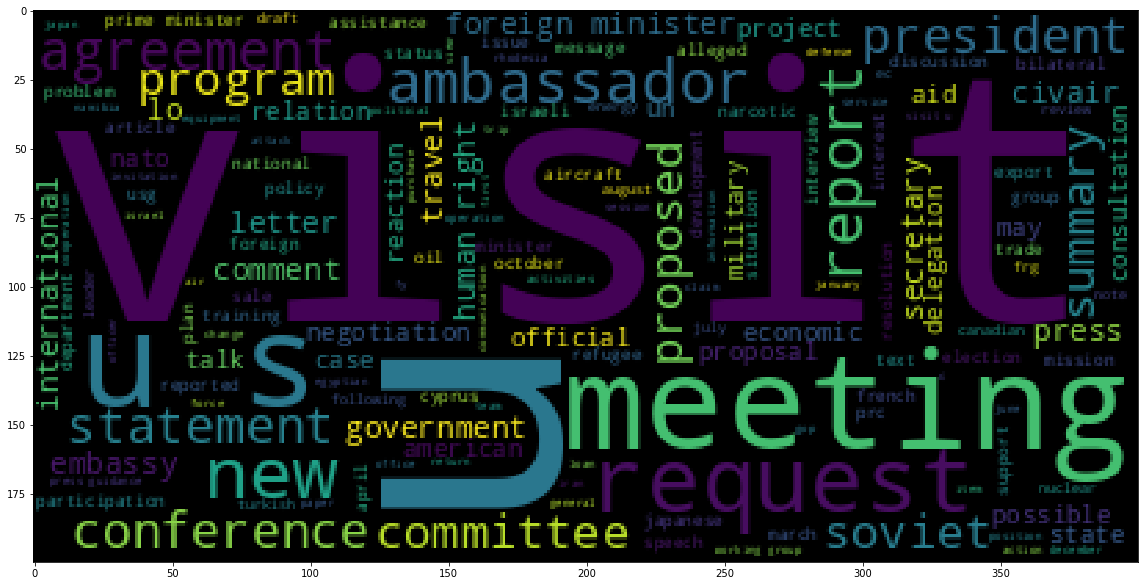

In [20]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(wordcloud, interpolation='nearest')
plt.tight_layout()

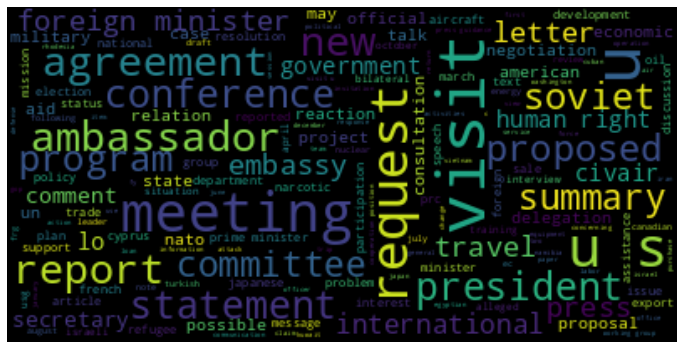

In [21]:
# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(cleaned)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [22]:
# The pil way (if you don't have matplotlib)
image = wordcloud.to_image()
image.show()

#### 1.2 - Reading/converting text from PDF file

In [23]:
print('Files in the folder:')
for i, w in enumerate(onlyfiles[0:]):
    print(i+1, '--' ,w)

Files in the folder:
1 -- ARTIGOS-RBE-COM-RESUMO.xlsx
2 -- AldousHuxley_bravenewworld.pdf
3 -- MarcelProust_EmBuscadoTempoPerdido.pdf
4 -- Possibly_Misclassified_Cables_Review.xlsx
5 -- RobertFrost_Poetry.pdf
6 -- abcnews-date-text.csv


In [24]:
text = textract.process(os.path.join(corpuspath,onlyfiles[1])).decode('utf-8')

In [25]:
text[0:100]

'Brave New World\nAldous Leonard Huxley\nFebruary 6, 2002\n\n\x0c\x0cContents\nOne\n\n5\n\nTwo\n\n17\n\nThree\n\n25\n\nFour\n'

In [26]:
print(text[0:100])

Brave New World
Aldous Leonard Huxley
February 6, 2002

Contents
One

5

Two

17

Three

25

Four



In [27]:
print(len(text))

376870


Cleaning and homogenizing texts:

In [28]:
cleaned_text = text.lower()
cleaned_text = re.sub(' +',' ', cleaned_text)              #Remove multiple spaces
cleaned_text = re.sub(r'\n\s*\n', '\n', cleaned_text)      #Remove multiple newlines

In [29]:
print(len(cleaned_text))

376470


In [30]:
print(cleaned_text[0:200])

brave new world
aldous leonard huxley
february 6, 2002
contents
one
5
two
17
three
25
four
41
2 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 45
five
51
2 . . . . . . . . . . . . .


In [31]:
list_words = cleaned_text.split()
list_words = [l.strip().lower() for l in list_words]
list_words = [l.strip(string.punctuation + '“”’“”') for l in list_words]
list_words = [l for l in list_words if l not in stop_en]

freqdist = Counter(list_words)
freqdist.most_common(20)

[('said', 315),
 ('one', 270),
 ('bernard', 215),
 ('savage', 195),
 ('like', 185),
 ('lenina', 180),
 ('don’t', 119),
 ('little', 114),
 ('made', 112),
 ('time', 108),
 ('voice', 105),
 ('two', 104),
 ('eyes', 101),
 ('man', 100),
 ('round', 99),
 ('would', 99),
 ('linda', 99),
 ('though', 97),
 ('face', 96),
 ('away', 94)]

Finding ocurrences of an word:

In [32]:
word = 'life'
pos = 0 
positions = []

while pos != -1:
    position = cleaned_text.find(word,pos+1)
    pos = position
    positions.append(position)
positions.pop()
print(f'The word is found {len(positions)} times in the following positions:')
print(positions)

The word is found 40 times in the following positions:
[5665, 40113, 51531, 53547, 68094, 72406, 78453, 81531, 89783, 109954, 111732, 112325, 116271, 117128, 135360, 143219, 153853, 158885, 163628, 173289, 198448, 204514, 208719, 210208, 211810, 218952, 221077, 224268, 253753, 257573, 276260, 286585, 290834, 311407, 319290, 326197, 328992, 335309, 356847, 367194]


Understanding contexts in which words occur:

In [33]:
# Pure Python
window = 18
for position in positions[0:20]:
    print(cleaned_text[position - window:position + window + len(word)].strip())

will bud, will proliferate, will divide.
mind too-all his life long. the mind th
of tightly
packed life, reeking with emo
dangers of family life. the world was fu
ht hundred simple lifers were mowed down
hroughout a whole lifetime.”
“. two roun
have got through life without ever touc
th fore-shortened life. forests of
centr
suffered all his life from the consciou
e end,
our larger life has but begun.”
a
g with a
galvanic life. the president re
th
an independent life. “ford!” they wer
, but of balanced life, of energies at
r
ever been in his life before. he
had em
t stimulating and
life-giving threat. wa
feel larger than life. but that,
as he
o indecent in her life.
and what made it
stopped beating, life seemed to have co
first time in his life, the face of a gi
rything. all your life.”
“but what is th


In [34]:
# Using NLTK

tknzr = nltk.tokenize.WordPunctTokenizer()
tokens = tknzr.tokenize(cleaned_text)
tokens = [token for token in tokens if token not in stop_en]
nltk_text = nltk.Text(tokens)

nltk_text.concordance(word.lower(), width=120, lines=20)

Displaying 20 of 35 matches:
um suggestions child ’ mind . child ’ mind . adult ’ mind life long . mind judges desires decides made suggestions . sug
lly , rabbit hole , midden , hot frictions tightly packed life , reeking emotion . suffocating intimacies , dangerous , 
al mattersour freud first reveal appalling dangers family life . world full fathers therefore full misery ; full mothers
. benito notoriously good natured . people said could got life without ever touching soma . malice bad tempers people ta
rst ring satellite suburbs . green maggoty fore shortened life . forests centrifugal bumble puppy towers gleamed trees .
dividuals . whereas physically defective bernard suffered life consciousness separate , quite recently , grown aware men
riend , annihilating twelve one ! long die , end , larger life begun .” twelve stanzas . time soma begun work . eyes sho
ilence stretched expectancy , quivering creeping galvanic life . president reached hand ; suddenly voice , deep strong v
; h

Words that occur in similar contexts than the query expression:

In [35]:
nltk_text.similar('love')

wanted linda


[Collocations](http://en.wikipedia.org/wiki/Collocation) are expressions of multiple words which commonly co-occur.  
http://www.nltk.org/howto/collocations.html  

In [36]:
nltk_text.collocation_list(num=20, window_size=20)

[('whisk', 'whisk'),
 ('mustapha', 'mond'),
 ('south', 'south'),
 ('orgy', 'porgy'),
 ('forty', 'seven'),
 ('want', 'want'),
 ('arch', 'songster'),
 ('dearest', 'dearest'),
 ('right', 'right'),
 ('east', 'south'),
 ('drop', 'morrow'),
 ('shook', 'head'),
 ('forty', 'forty'),
 ('ending', 'better'),
 ('every', 'one'),
 ('mind', 'suggestions'),
 ('bye', 'dearest'),
 ('seven', 'forty'),
 ('ending', 'mending'),
 ('zip', 'zip')]

Fnding bigrams using [Pointwise Mutual Information](http://en.wikipedia.org/wiki/Pointwise_mutual_information).

In [37]:
max_items = 30
freq_min_b = 10
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder2 = nltk.collocations.BigramCollocationFinder.from_words(nltk_text)
finder2.apply_word_filter(lambda w: w in string.punctuation)
finder2.apply_freq_filter(freq_min_b)
for a, b in finder2.nbest(bigram_measures.pmi, max_items):
    print(a, b)

orgy porgy
community songster
mustapha mond
arch community
synthetic music
brave new
half gramme
shook head
helmholtz watson
henry foster
men women
new world
young man
?” asked
bernard marx
!” shouted
two thousand
old man
,” added
,” said
one else
every one
,” explained
,” answered
said mustapha
,” whispered
said controller
one another
,” repeated
’ understand


Same bigrams, using raw frequency

In [38]:
for a, b in (finder2.above_score(bigram_measures.raw_freq, 20.0 / len(list(nltk.bigrams(tokens))))):
        print(a, b)

.” “
“ ’
,” said
?” “
“ oh
?” asked
“ well
mustapha mond
bernard ’
“ yes
shook head
’ like
every one
young man
!” said
“ ,”
said lenina
’ got
’ know
“ ?”
,” added
,” went
lenina ’
said bernard


Finding Trigrams

In [39]:
max_items = 30
freq_min_t = 6
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder3 = nltk.collocations.TrigramCollocationFinder.from_words(nltk_text)
finder3.apply_word_filter(lambda w: w in string.punctuation)
finder3.apply_ngram_filter(lambda w1, w2, w3:  w1 in ['da', 'de', 'das'])
finder3.apply_freq_filter(freq_min_t)
for a, b, c in finder3.nbest(trigram_measures.pmi, max_items):
    print(a, b, c)

deputy sub bursar
ending better mending
arch community songster
brave new world
.” .. ...
.. ... “
“ orgy porgy
said mustapha mond
years ’ war
every one else
nine years ’
“ brave new
hog ’ back
?” asked savage
“ want whip
,” said mustapha
,” said controller
,” said mr
,” said fanny
,” said lenina
,” said henry
,” said director
,” said helmholtz
,” said bernard
,” said savage
like ,” said
.” “ yes
?” “ well
.” “ well
.” “ oh


Trigrams with raw frequency

In [40]:
for a, b, c in finder3.above_score(trigram_measures.raw_freq, 20.0 / len(list(nltk.trigrams(tokens)))):
        print (a, b, c)

.” “ ’
,” said lenina


In [41]:
from nltk.util import ngrams
n = 4
xgrams = ngrams(tokens, n)
xgrams_counter = Counter(xgrams)
xgrams_counter.most_common(20)

[(('.', '.', '.', '.'), 116),
 (('.', '“', 'oh', ','), 29),
 (('.', 'h', '.', 'c'), 26),
 (('h', '.', 'c', '.'), 24),
 (('shook', 'head', '.', '“'), 16),
 ((',”', 'said', ',', '“'), 16),
 (('.', '“', 'well', ','), 15),
 ((',”', 'said', '.', '“'), 12),
 ((',”', 'said', 'mustapha', 'mond'), 11),
 (('.”', '“', 'well', ','), 10),
 (('“', 'well', ',', '’'), 9),
 (('.', '“', 'yes', ','), 9),
 ((',”', 'said', 'mr', '.'), 8),
 (('said', 'mr', '.', 'foster'), 8),
 ((',”', 'said', 'lenina', '.'), 8),
 (('.”', '“', 'yes', ','), 8),
 (('“', 'oh', ',', '’'), 8),
 ((',”', 'said', 'lenina', ','), 8),
 (('.', '“', 'brave', 'new'), 8),
 (('“', 'brave', 'new', 'world'), 8)]

/home/renato/Documentos/envs/default/lib/python3.8/site-packages/nltk/draw/__init__.py:15: UserWarning: nltk.draw package not loaded (please install Tkinter library).
  warnings.warn("nltk.draw package not loaded (please install Tkinter library).")


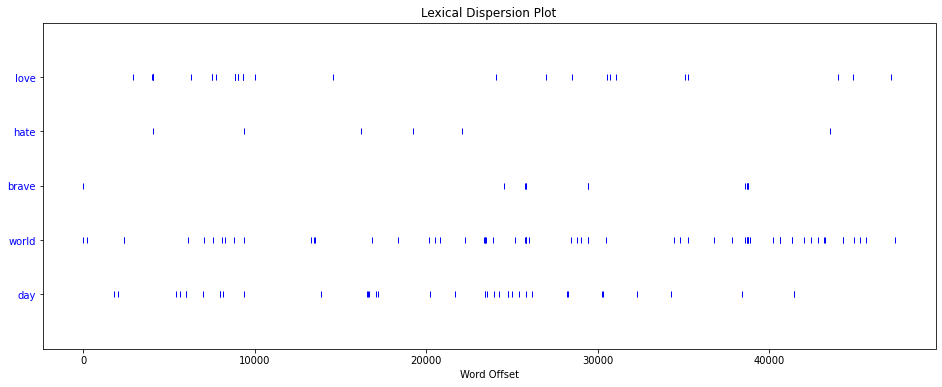

In [42]:
dispersion_words = ['love', 'hate', 'brave','world', 'day']
plt.figure(figsize=(16,6))
nltk_text.dispersion_plot(dispersion_words)

Different ways to visualize frequent words:

In [43]:
freqdist.most_common(100)

[('said', 315),
 ('one', 270),
 ('bernard', 215),
 ('savage', 195),
 ('like', 185),
 ('lenina', 180),
 ('don’t', 119),
 ('little', 114),
 ('made', 112),
 ('time', 108),
 ('voice', 105),
 ('two', 104),
 ('eyes', 101),
 ('man', 100),
 ('round', 99),
 ('would', 99),
 ('linda', 99),
 ('though', 97),
 ('face', 96),
 ('away', 94),
 ('still', 93),
 ('went', 92),
 ('back', 91),
 ('know', 89),
 ('room', 88),
 ('well', 88),
 ('every', 86),
 ('it’s', 84),
 ('old', 82),
 ('director', 81),
 ('suddenly', 81),
 ('could', 81),
 ('even', 80),
 ('head', 76),
 ('came', 76),
 ('course', 75),
 ('hand', 75),
 ('helmholtz', 75),
 ('go', 73),
 ('men', 73),
 ('three', 71),
 ('young', 71),
 ('say', 71),
 ('first', 71),
 ('oh', 71),
 ('come', 70),
 ('words', 68),
 ('another', 68),
 ('began', 68),
 ('see', 68),
 ('long', 67),
 ('door', 67),
 ('make', 67),
 ('i’m', 67),
 ('asked', 67),
 ('something', 66),
 ('good', 65),
 ('looked', 65),
 ('world', 63),
 ('think', 63),
 ('silence', 62),
 ('almost', 62),
 ('got', 62

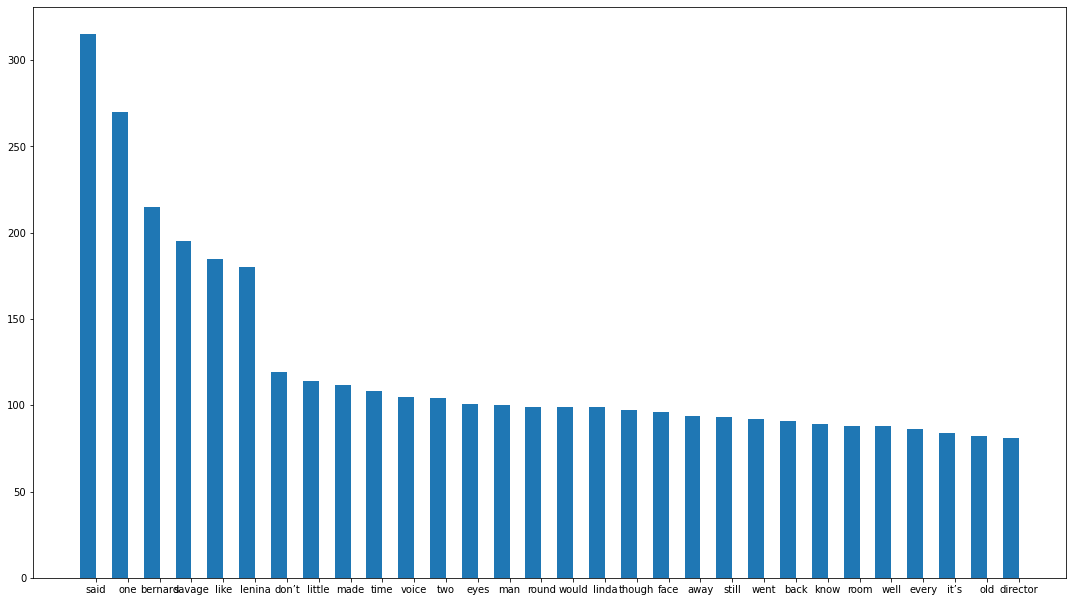

In [44]:
labels, values = zip(*freqdist.most_common(30))

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

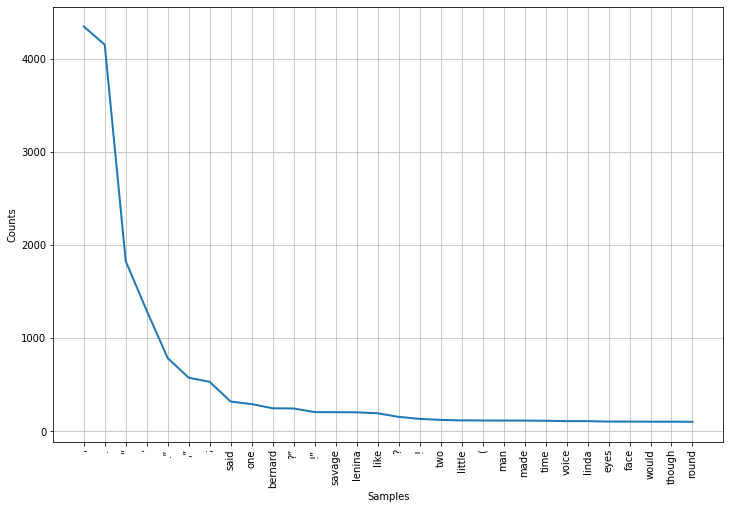

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [45]:
fd_words = nltk.FreqDist(tokens)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(30)

Cumulative distribution of frequencies:

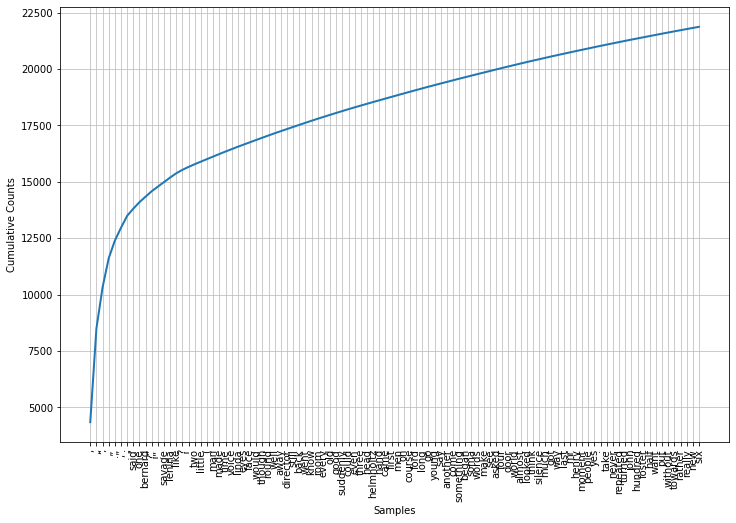

<AxesSubplot:xlabel='Samples', ylabel='Cumulative Counts'>

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(100, cumulative = True)

### 2 - Extracting text from html pages using [Goose](https://github.com/goose3/goose3)

In [47]:
from goose3 import Goose

url = 'https://edition.cnn.com/travel/article/worlds-fastest-trains-cmd/index.html'

g = Goose()
#g = Goose(Goose({'use_meta_language': False, 'target_language':'en', 'parser_class':'lxml'}))

article = g.extract(url=url)

In [48]:
[l for l in article.links if l.startswith('http')]

['https://edition.cnn.com/travel/article/china-fastest-maglev-train-intl-hnk/index.html',
 'https://edition.cnn.com/travel/article/china-high-speed-rail-cmd/index.html',
 'https://www.cnn.com/travel/article/morocco-high-speed-tgv-trains',
 'https://www.cnn.com/travel/article/spain-high-speed-rail-network',
 'https://www.cnn.com/travel/article/italy-high-speed-trains-alitalia',
 'https://www.cnn.com/travel/article/haramain-high-speed-rail-hajj-saudi-arabia']

In [49]:
article.title

"Flying without wings: The world's fastest trains"

In [50]:
article.meta_description

"High-speed trains offer greener alternatives to short-haul flights. From China's floating Maglev trains to France's border busting TGVs, these are the fastest railway services you can ride today."

In [51]:
article.cleaned_text[:]

'As the world faces up to climate change, short-haul flights look increasingly unattractive to many travelers. The flygskam (flight shame) phenomenon that started in Scandinavia is already inspiring many travelers to reduce their reliance on airlines.\n\nUntil someone proves otherwise, high-speed rail is the most effective alternative to air travel for journeys of up to 1,100 kilometers (700 miles). Shuttling passengers between city centers at speeds of 290 kph (180 mph) or more, it offers a compelling combination of speed and convenience.\n\nRail\'s ability to move huge numbers of people quickly makes it far more efficient than unproven, low-capacity concepts such as Hyperloop.\n\nSince the 1980s, hundreds of billions of dollars have been invested in new high-speed, high-capacity railways across Europe and Asia, pioneered by Japan\'s Shinkansen and the Train a Grand Vitesse (TGV) in France.\n\nIn the last decade, China has become the undisputed world leader, building a 38,000-kilomete

In [52]:
print(article.top_image)

None


### 3 - Translation, Part of Speech, advanced NLP functions

#### 3.1 Using [Textblob](http://textblob.readthedocs.io/en/dev/) ([Github](https://github.com/sloria/TextBlob))

[Another article](https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/)

In [53]:
from textblob import TextBlob
from textblob import Word

In [54]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /home/renato/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/renato/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/renato/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/renato/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /home/renato/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/renato/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [55]:
text_en = '''
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact.
Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists, etc., fearful of
artificial intelligence run rampant.
'''

text_de = '''
Familie Müller plant ihren Urlaub. Sie geht in ein Reisebüro und lässt sich 
von einem Angestellten beraten. Als Reiseziel wählt sie Mallorca aus. 
Familie Müller bucht einen Flug auf die Mittelmeerinsel. Sie bucht außerdem 
zwei Zimmer in einem großen Hotel direkt am Strand. Familie Müller badet gerne im Meer.
Am Abflugtag fahren Herr und Frau Müller mit ihren beiden Kindern im Taxi zum 
Flughafen. Dort warten schon viele Urlauber. Alle wollen nach Mallorca fliegen. 
Familie Müller hat viel Gepäck dabei: drei große Koffer und zwei Taschen. 
Die Taschen sind Handgepäck. Familie Müller nimmt sie mit in das Flugzeug. 
Am Flugschalter checkt die Familie ein und erhält ihre Bordkarten. Die Angestellte 
am Flugschalter erklärt Herrn Müller den Weg zum Flugsteig. Es ist nicht mehr 
viel Zeit bis zum Abflug. Familie Müller geht durch die Sicherheitskontrolle. 
Als alle das richtige Gate erreichen, setzen sie sich in den Wartebereich. 
Kurz darauf wird ihre Flugnummer aufgerufen und Familie Müller steigt mit vielen 
anderen Passagieren in das Flugzeug nach Mallorca. Beim Starten fühlt sich Herr Müller 
nicht wohl. Ihm wird ein wenig übel. Nach zwei Stunden landet das Flugzeug. 
Am Gepäckband warten alle Passagiere noch auf ihr fehlendes Gepäck. Danach 
kann endlich der Urlaub beginnen.
'''

In [56]:
blob_en = TextBlob(text_en)
blob_de = TextBlob(text_de)

In [57]:
for s in blob_en.sentences:
    print(f'Sentence: {s} \n')

Sentence: 
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact. 

Sentence: Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists, etc., fearful of
artificial intelligence run rampant. 



In [58]:
for s in blob_de.sentences:
    print(f'Sentence: {s} \n')

Sentence: 
Familie Müller plant ihren Urlaub. 

Sentence: Sie geht in ein Reisebüro und lässt sich 
von einem Angestellten beraten. 

Sentence: Als Reiseziel wählt sie Mallorca aus. 

Sentence: Familie Müller bucht einen Flug auf die Mittelmeerinsel. 

Sentence: Sie bucht außerdem 
zwei Zimmer in einem großen Hotel direkt am Strand. 

Sentence: Familie Müller badet gerne im Meer. 

Sentence: Am Abflugtag fahren Herr und Frau Müller mit ihren beiden Kindern im Taxi zum 
Flughafen. 

Sentence: Dort warten schon viele Urlauber. 

Sentence: Alle wollen nach Mallorca fliegen. 

Sentence: Familie Müller hat viel Gepäck dabei: drei große Koffer und zwei Taschen. 

Sentence: Die Taschen sind Handgepäck. 

Sentence: Familie Müller nimmt sie mit in das Flugzeug. 

Sentence: Am Flugschalter checkt die Familie ein und erhält ihre Bordkarten. 

Sentence: Die Angestellte 
am Flugschalter erklärt Herrn Müller den Weg zum Flugsteig. 

Sentence: Es ist nicht mehr 
viel Zeit bis zum Abflug. 

Sentence: 

In [59]:
blob_en.sentences[1].words

WordList(['Snide', 'comparisons', 'to', 'gelatin', 'be', 'damned', 'it', "'s", 'a', 'concept', 'with', 'the', 'most', 'devastating', 'of', 'potential', 'consequences', 'not', 'unlike', 'the', 'grey', 'goo', 'scenario', 'proposed', 'by', 'technological', 'theorists', 'etc', 'fearful', 'of', 'artificial', 'intelligence', 'run', 'rampant'])

Functions applied to the Word object:  

In [60]:
w = Word('Platform')
w.pluralize()

'Platforms'

In [61]:
blob_en.sentences[1].words.singularize()

WordList(['Snide', 'comparison', 'to', 'gelatin', 'be', 'damned', 'it', "'", 'a', 'concept', 'with', 'the', 'most', 'devastating', 'of', 'potential', 'consequence', 'not', 'unlike', 'the', 'grey', 'goo', 'scenario', 'proposed', 'by', 'technological', 'theorist', 'etc', 'fearful', 'of', 'artificial', 'intelligence', 'run', 'rampant'])

In [62]:
w = Word('running')
w.lemmatize("v") ## v here represents verb

'run'

POS tags  

In [63]:
blob_en.tags[0:10]

[('The', 'DT'),
 ('titular', 'JJ'),
 ('threat', 'NN'),
 ('of', 'IN'),
 ('The', 'DT'),
 ('Blob', 'NNP'),
 ('has', 'VBZ'),
 ('always', 'RB'),
 ('struck', 'VBN'),
 ('me', 'PRP')]

In [64]:
blob_de.tags[0:10]

[('Familie', 'NNP'),
 ('Müller', 'NNP'),
 ('plant', 'NN'),
 ('ihren', 'NN'),
 ('Urlaub', 'NNP'),
 ('Sie', 'NNP'),
 ('geht', 'NN'),
 ('in', 'IN'),
 ('ein', 'JJ'),
 ('Reisebüro', 'NNP')]

Ngrams  

In [65]:
for ngram in blob_en.ngrams(2):
    print(ngram)

['The', 'titular']
['titular', 'threat']
['threat', 'of']
['of', 'The']
['The', 'Blob']
['Blob', 'has']
['has', 'always']
['always', 'struck']
['struck', 'me']
['me', 'as']
['as', 'the']
['the', 'ultimate']
['ultimate', 'movie']
['movie', 'monster']
['monster', 'an']
['an', 'insatiably']
['insatiably', 'hungry']
['hungry', 'amoeba-like']
['amoeba-like', 'mass']
['mass', 'able']
['able', 'to']
['to', 'penetrate']
['penetrate', 'virtually']
['virtually', 'any']
['any', 'safeguard']
['safeguard', 'capable']
['capable', 'of']
['of', 'as']
['as', 'a']
['a', 'doomed']
['doomed', 'doctor']
['doctor', 'chillingly']
['chillingly', 'describes']
['describes', 'it']
['it', 'assimilating']
['assimilating', 'flesh']
['flesh', 'on']
['on', 'contact']
['contact', 'Snide']
['Snide', 'comparisons']
['comparisons', 'to']
['to', 'gelatin']
['gelatin', 'be']
['be', 'damned']
['damned', 'it']
['it', "'s"]
["'s", 'a']
['a', 'concept']
['concept', 'with']
['with', 'the']
['the', 'most']
['most', 'devastating'

Noun Phrase Extraction

In [66]:
blob_en.noun_phrases

WordList(['titular threat', 'blob', 'ultimate movie monster', 'amoeba-like mass', 'snide', 'potential consequences', 'grey goo scenario', 'technological theorists', 'artificial intelligence run rampant'])

In [67]:
blob_de.noun_phrases

WordList(['familie müller', 'plant ihren', 'urlaub', 'sie', 'reisebüro', 'und lässt sich von einem', 'angestellten', 'als reiseziel', 'wählt sie', 'mallorca', 'familie müller', 'bucht einen', 'flug', 'mittelmeerinsel', 'sie', 'bucht außerdem zwei', 'zimmer', 'einem großen hotel direkt', 'strand', 'familie müller', 'badet gerne im', 'meer', 'am abflugtag', 'herr', 'frau müller', 'mit ihren beiden', 'kindern', 'taxi', 'flughafen', 'dort', 'warten schon viele', 'urlauber', 'alle', 'wollen nach', 'mallorca', 'familie müller', 'hat viel', 'gepäck', 'drei große', 'koffer', 'und zwei', 'taschen', 'die taschen', 'handgepäck', 'familie müller', 'nimmt sie mit', 'flugzeug', 'am flugschalter', 'familie', 'ein und erhält ihre', 'bordkarten', 'die angestellte', 'flugschalter', 'herrn müller', 'weg', 'flugsteig', 'es', 'ist nicht mehr viel', 'zeit', 'bis zum', 'abflug', 'familie müller', 'geht durch', 'sicherheitskontrolle', 'als', 'alle das richtige gate erreichen', 'setzen sie sich', 'wartebereich

Sentiment Analysis  

In [68]:
for sentence in blob_en.sentences:
    print(sentence.sentiment.polarity)

0.06000000000000001
-0.34166666666666673


Spellcheck

In [69]:
sentence = TextBlob('The Austrien Centre for Digital Humanities and Cultural Heritaige from the Austrian Academy of Sciences')
sentence.correct()

TextBlob("The Austrian Centre for Digital Humanities and Cultural Heritage from the Austrian Academy of Sciences")

In [70]:
blob_en.words[5].spellcheck()

[('Low', 0.19878603945371776),
 ('Blow', 0.10925644916540213),
 ('Club', 0.10773899848254932),
 ('Clot', 0.1062215477996965),
 ('Slow', 0.09863429438543247),
 ('Flow', 0.07283763277693475),
 ('Lot', 0.05311077389984825),
 ('Mob', 0.03945371775417299),
 ('Glow', 0.03338391502276176),
 ('Log', 0.030349013657056147),
 ('Sob', 0.028831562974203338),
 ('Globe', 0.024279210925644917),
 ('Plot', 0.018209408194233688),
 ('Job', 0.01669195751138088),
 ('Plow', 0.013657056145675266),
 ('Rob', 0.007587253414264037),
 ('Slab', 0.006069802731411229),
 ('Los', 0.004552352048558422),
 ('Bob', 0.004552352048558422),
 ('Knob', 0.0030349013657056147),
 ('Flop', 0.0030349013657056147),
 ('Flog', 0.0030349013657056147),
 ('Blot', 0.0030349013657056147),
 ('Slot', 0.0015174506828528073),
 ('Slop', 0.0015174506828528073),
 ('Loi', 0.0015174506828528073),
 ('Lo', 0.0015174506828528073),
 ('Lb', 0.0015174506828528073),
 ('Lab', 0.0015174506828528073),
 ('Cob', 0.0015174506828528073),
 ('Bloc', 0.0015174506828

Text classification

In [71]:
training = [
('Tom Holland is a terrible spiderman.','neg'),
('a terrible Javert (Russell Crowe) ruined Les Miserables for me...','neg'),
('The Dark Knight Rises is the greatest superhero movie ever!','pos'),
('Fantastic Four should have never been made.','neg'),
('Wes Anderson is my favorite director!','pos'),
('Captain America 2 is pretty awesome.','pos'),
("Let's pretend \"Batman and Robin\" never happened..",'neg'),
]

testing = [
('Superman was never an interesting character.','neg'),
('Fantastic Mr Fox is an awesome film!','pos'),
('Dragonball Evolution is simply terrible!!','neg')
]

In [72]:
from textblob import classifiers
nb_classifier = classifiers.NaiveBayesClassifier(training)
dt_classifier = classifiers.DecisionTreeClassifier(training)

In [73]:
print (nb_classifier.accuracy(testing))

1.0


In [74]:
print (dt_classifier.accuracy(testing))

0.6666666666666666


In [75]:
nb_classifier.show_informative_features(4)

Most Informative Features
            contains(is) = True              pos : neg    =      2.9 : 1.0
             contains(a) = False             pos : neg    =      1.8 : 1.0
         contains(never) = False             pos : neg    =      1.8 : 1.0
      contains(terrible) = False             pos : neg    =      1.8 : 1.0


In [76]:
blob = TextBlob('the weather is terrible!', classifier=dt_classifier)
print (blob.classify())

pos


#### 3.2 Using [Spacy](https://spacy.io/)

[Doc 1](https://spacy.io/usage/spacy-101#lightning-tour), [Doc 2](https://github.com/explosion/spacy-notebooks), [Doc 3](https://github.com/explosion/spacy-notebooks/blob/master/notebooks/conference_notebooks/advanced_text_analysis.ipynb)

Downloading the language models from Spacy

In [77]:
#!python -m spacy download en_core_web_sm
#!python -m spacy download de_core_news_sm
#!python -m spacy download pt_core_news_sm
#!python -m spacy download de_core_news_md

!python -m spacy validate

2021-12-10 07:41:14.514230: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-10 07:41:14.514258: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.2.1) =================
ℹ spaCy installation:
/home/renato/Documentos/envs/default/lib/python3.8/site-packages/spacy

NAME              SPACY            VERSION                            
pt_core_news_sm   >=3.2.0,<3.3.0   3.2.0   ✔
de_core_news_sm   >=3.2.0,<3.3.0   3.2.0   ✔
de_core_news_md   >=3.2.0,<3.3.0   3.2.0   ✔
en_core_web_sm    >=3.2.0,<3.3.0   3.2.0   ✔



Load resources and process text

In [78]:
import spacy

In [79]:
en_nlp = spacy.load('en_core_web_sm')
de_nlp = spacy.load('de_core_news_sm')
pt_nlp = spacy.load('pt_core_news_sm')

In [80]:
text_german = '''
Der du von dem Himmel bist,
Alles Leid und Schmerzen stillest,
Den, der doppelt elend ist,
Doppelt mit Erquickung füllest;
Ach, ich bin des Treibens müde!
Was soll all der Schmerz und Lust?
Süßer Friede,
Komm, ach komm in meine Brust!
'''

text_english = '''
somewhere i have never travelled, gladly beyond
any experience,your eyes have their silence:
in your most frail gesture are things which enclose me,
or which i cannot touch because they are too near.
Your slightest look easily will unclose me
though i have closed myself as fingers,
you open always petal by petal myself as Spring opens
(touching skilfully, mysteriously) her first rose.
Or if your wish be to close me,i and
my life will shut very beautifully,suddenly,
as when the heart of this flower imagines
the snow carefully everywhere descending;
nothing which we are to perceive in this world equals
the power of your intense fragility: whose texture
compels me with the colour of its countries,
rendering death and forever with each breathing.
I do not know what it is about you that closes
and opens; only something in me understands
the voice of your eyes is deeper than all roses)
nobody, not even the rain, has such small hands.

'''

text_portuguese = '''
Ora (direis) ouvir estrelas! Certo
Perdeste o senso!" E eu vos direi, no entanto,
Que, para ouvi-las, muita vez desperto
E abro as janelas, pálido de espanto...

E conversamos toda a noite, enquanto
A via-láctea, como um pálio aberto,
Cintila. E, ao vir do sol, saudoso e em pranto,
Inda as procuro pelo céu deserto.

Direis agora: "Tresloucado amigo!
Que conversas com elas? Que sentido
Tem o que dizem, quando estão contigo?"

E eu vos direi: "Amai para entendê-las!
Pois só quem ama pode ter ouvido
Capaz de ouvir e de entender estrelas. 
'''

In [81]:
en_doc = en_nlp(text_english)
de_doc = de_nlp(text_german)
pt_doc = pt_nlp(text_portuguese)

Each SpaCy document is already tokenized into words, which are accessible by iterating over the document:

In [82]:
print(en_doc[0:7])


somewhere i have never travelled,


You can also iterate over the sentences. doc.sents is a generator object, so we can use next():

In [83]:
en_Sents = list(en_doc.sents)
print(en_Sents)

[
somewhere i have never travelled, gladly beyond
any experience,your eyes have their silence:
in your most frail gesture are things which enclose me,
or which i cannot touch because they are too near., 
Your slightest look easily will unclose me
though i have closed myself as fingers,
you open always petal by petal myself as Spring opens
(touching skilfully, mysteriously) her first rose., 
Or if your wish be to close me,i and
my life will shut very beautifully,suddenly,
as when the heart of this flower imagines
the snow carefully everywhere descending;
nothing which we are to perceive in this world equals
the power of your intense fragility: whose texture
compels me with the colour of its countries,
rendering death and forever with each breathing., 
I do not know what it is about you that closes
and opens; only something in me understands
the voice of your eyes is deeper than all roses), 
nobody, not even the rain, has such small hands., 

]


For example, let's find the longest sentence(s):

In [84]:
SentenceLengths = [len(sent) for sent in en_Sents]
[sent for sent in en_Sents if len(sent) == max(SentenceLengths)]

[
 Or if your wish be to close me,i and
 my life will shut very beautifully,suddenly,
 as when the heart of this flower imagines
 the snow carefully everywhere descending;
 nothing which we are to perceive in this world equals
 the power of your intense fragility: whose texture
 compels me with the colour of its countries,
 rendering death and forever with each breathing.]

Exploring Words: each word has a huge number of properties:

In [85]:
print(en_doc[2])
print(type(en_doc[2]))

i
<class 'spacy.tokens.token.Token'>


In [86]:
[prop for prop in dir(en_doc[2]) if not prop.startswith('_')]

['ancestors',
 'check_flag',
 'children',
 'cluster',
 'conjuncts',
 'dep',
 'dep_',
 'doc',
 'ent_id',
 'ent_id_',
 'ent_iob',
 'ent_iob_',
 'ent_kb_id',
 'ent_kb_id_',
 'ent_type',
 'ent_type_',
 'get_extension',
 'has_dep',
 'has_extension',
 'has_head',
 'has_morph',
 'has_vector',
 'head',
 'i',
 'idx',
 'iob_strings',
 'is_alpha',
 'is_ancestor',
 'is_ascii',
 'is_bracket',
 'is_currency',
 'is_digit',
 'is_left_punct',
 'is_lower',
 'is_oov',
 'is_punct',
 'is_quote',
 'is_right_punct',
 'is_sent_end',
 'is_sent_start',
 'is_space',
 'is_stop',
 'is_title',
 'is_upper',
 'lang',
 'lang_',
 'left_edge',
 'lefts',
 'lemma',
 'lemma_',
 'lex',
 'lex_id',
 'like_email',
 'like_num',
 'like_url',
 'lower',
 'lower_',
 'morph',
 'n_lefts',
 'n_rights',
 'nbor',
 'norm',
 'norm_',
 'orth',
 'orth_',
 'pos',
 'pos_',
 'prefix',
 'prefix_',
 'prob',
 'rank',
 'remove_extension',
 'right_edge',
 'rights',
 'sent',
 'sent_start',
 'sentiment',
 'set_extension',
 'set_morph',
 'shape',
 'sh

Using just the indices (.i), we can make a lexical dispersion plot for the occurrences of that word in the novel. (This is just the SpaCy equivalent of the lexical dispersion plot from the NLTK)

In [87]:
en_doc[2].i

2

In [88]:
def locations(needle, haystack): 
    """ 
    Make a list of locations, bin those into a histogram, 
    and finally put it into a Pandas Series object so that we
    can later make it into a DataFrame. 
    """
    return pd.Series(np.histogram([word.i for word in haystack if word.text.lower() == needle], bins=50)[0])

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

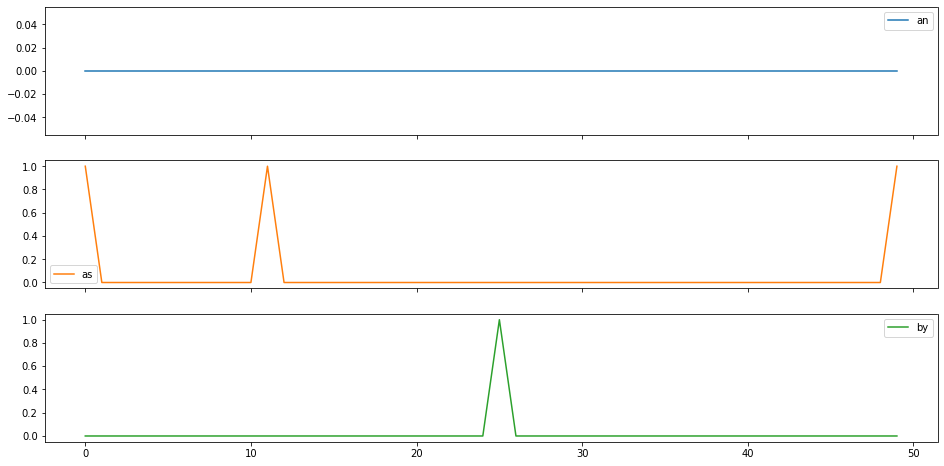

In [89]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

pd.DataFrame(
    {name: locations(name.lower(), en_doc) 
     for name in ['an', 'as', 'by']}
).plot(subplots=True)

Exploring [Named Entities](https://spacy.io/api/annotation)

Named entities can be accessed through doc.ents

In [90]:
news_text = '''
Mexico City (CNN)At least 54 people were killed and more than 100 injured when a truck overturned in southern Mexico on Thursday, with most of the victims believed to be migrants from Central America, according to local authorities.
The incident happened in Mexico's Chiapas state, which borders Guatemala, when the truck carrying dozens of migrants crashed. Photos from the scene show the truck on its side next to a footbridge and bodies laid out on the road wrapped in body bags.
State Governor Rutilio Escandón tweeted that in addition to the deaths, 105 people were injured in the crash -- among them are 83 men and 22 and women.
'''

en_doc2 = en_nlp(news_text)

In [91]:
set([w.label_ for w in en_doc2.ents])

{'CARDINAL', 'DATE', 'GPE', 'LOC', 'PERSON'}

In [92]:
[ent for ent in en_doc2.ents if ent.label_ == 'LOC']

[Central America]

In [93]:
[ent for ent in en_doc2.ents if ent.label_ == 'GPE']

[Mexico City, Mexico, Mexico, Chiapas, Guatemala]

Parts of Speech  

Each word already has a part of speech and a tag associated with it.

In [94]:
tagDict = {w.pos: w.pos_ for w in en_doc2} 
tagDict

{103: 'SPACE',
 96: 'PROPN',
 97: 'PUNCT',
 86: 'ADV',
 93: 'NUM',
 92: 'NOUN',
 87: 'AUX',
 100: 'VERB',
 89: 'CCONJ',
 84: 'ADJ',
 85: 'ADP',
 98: 'SCONJ',
 90: 'DET',
 94: 'PART',
 95: 'PRON'}

<AxesSubplot:>

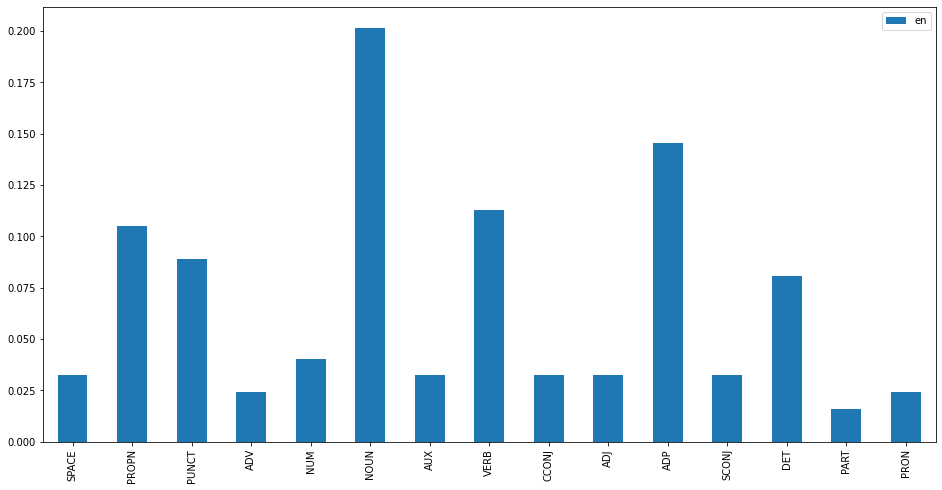

In [95]:
en_docPOS = pd.Series(en_doc2.count_by(spacy.attrs.POS))/len(en_doc2)

df = pd.DataFrame([en_docPOS], index=['en'])
df.columns = [tagDict[column] for column in df.columns]
df.T.plot(kind='bar')

In [96]:
en_docProns = [w for w in en_doc2 if w.pos_ == 'PRON']
Counter([w.text.strip() for w in en_docProns]).most_common(10)

[('which', 1), ('its', 1), ('them', 1)]

In [97]:
en_docSents = [sent for sent in en_doc2.sents if 'Mexico' in sent.text]
en_docSents

[
 Mexico City (CNN)At least 54 people were killed and more than 100 injured when a truck overturned in southern Mexico on Thursday, with most of the victims believed to be migrants from Central America, according to local authorities.,
 
 The incident happened in Mexico's Chiapas state, which borders Guatemala, when the truck carrying dozens of migrants crashed.]

In [98]:
for word in en_docSents[1]: 
    print(word, word.tag_, word.pos_)


 _SP SPACE
The DT DET
incident NN NOUN
happened VBD VERB
in IN ADP
Mexico NNP PROPN
's POS PART
Chiapas NNP PROPN
state NN NOUN
, , PUNCT
which WDT PRON
borders VBZ VERB
Guatemala NNP PROPN
, , PUNCT
when WRB SCONJ
the DT DET
truck NN NOUN
carrying VBG VERB
dozens NNS NOUN
of IN ADP
migrants NNS NOUN
crashed VBN VERB
. . PUNCT


Dependency Parsing  

Now let's analyze the structure of the sentence.  

This sentence has lots of properties:  

In [99]:
[prop for prop in dir(en_docSents[1]) if not prop.startswith('_')]

['as_doc',
 'char_span',
 'conjuncts',
 'doc',
 'end',
 'end_char',
 'ent_id',
 'ent_id_',
 'ents',
 'get_extension',
 'get_lca_matrix',
 'has_extension',
 'has_vector',
 'kb_id',
 'kb_id_',
 'label',
 'label_',
 'lefts',
 'lemma_',
 'n_lefts',
 'n_rights',
 'noun_chunks',
 'orth_',
 'remove_extension',
 'rights',
 'root',
 'sent',
 'sentiment',
 'sents',
 'set_extension',
 'similarity',
 'start',
 'start_char',
 'subtree',
 'tensor',
 'text',
 'text_with_ws',
 'to_array',
 'vector',
 'vector_norm',
 'vocab']

To drill down into the sentence, we can start with the root:

In [100]:
en_docSents[1].root

happened

In [101]:
list(en_docSents[1].root.children)

[, incident, in, .]

In [102]:
for word in en_docSents[1]: 
    print(word, ': ', str(list(word.children)))


 :  []
The :  []
incident :  [The]
happened :  [
, incident, in, .]
in :  [state]
Mexico :  ['s]
's :  []
Chiapas :  []
state :  [Mexico, Chiapas, ,, borders]
, :  []
which :  []
borders :  [which, Guatemala]
Guatemala :  [,, crashed]
, :  []
when :  []
the :  []
truck :  [the, carrying]
carrying :  [dozens]
dozens :  [of]
of :  [migrants]
migrants :  []
crashed :  [when, truck]
. :  []


Probabilities

SpaCy has a list of probabilities for English words, and these probabilities are automatically associated with each word once we parse the document.  
Let's see what the distribution is like:

<AxesSubplot:>

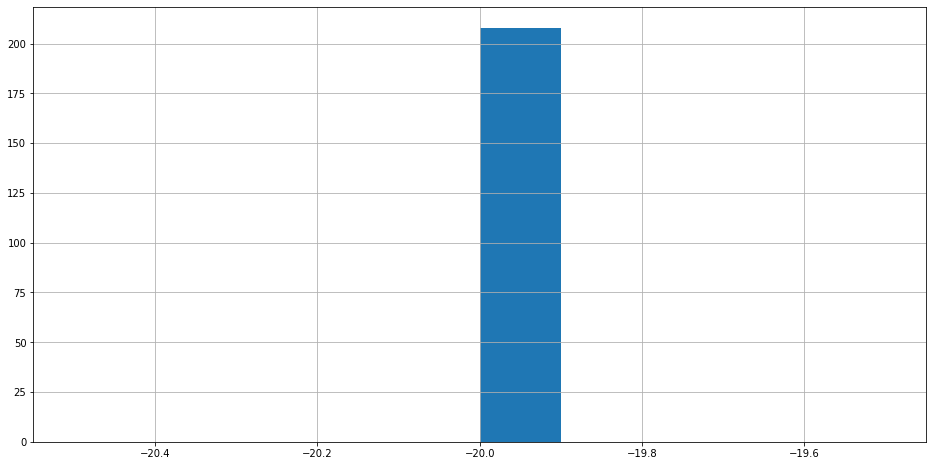

In [103]:
probabilities = [word.prob for word in en_doc] 
pd.Series(probabilities).hist()

Let's peek at some of the improbable words

In [104]:
list(set([word.text.strip().lower() for word in en_doc if word.prob < -19]))[:20]

['',
 'too',
 ',',
 'to',
 'descending',
 'roses',
 'shut',
 'heart',
 'rose',
 'know',
 'be',
 'touching',
 'enclose',
 'look',
 ':',
 'perceive',
 'always',
 'because',
 'do',
 'something']

In [105]:
Counter([word.text.strip().lower() 
         for word in en_doc 
         if word.prob < -19.5]).most_common(20)

[('', 21),
 (',', 11),
 ('your', 6),
 ('the', 6),
 ('i', 5),
 ('me', 5),
 ('.', 4),
 ('of', 4),
 ('have', 3),
 ('in', 3),
 ('are', 3),
 ('which', 3),
 ('not', 3),
 ('as', 3),
 ('and', 3),
 ('eyes', 2),
 (':', 2),
 ('or', 2),
 ('will', 2),
 ('myself', 2)]

In [106]:
def ngrams(doc, n): 
    doc = [word for word in doc 
           if word.is_alpha # Get rid of punctuation
           if not word.text.isupper()] # Get rid of all-caps speaker headings
    return list(zip(*[doc[i:] for i in range(n)]))

In [107]:
docGrams = set(ngrams(en_doc, 3))

In [108]:
for gram in docGrams: 
    if sum([word.prob for word in gram]) < -40: 
        print(gram)

(what, it, is)
(as, when, the)
(is, deeper, than)
(in, me, understands)
(look, easily, will)
(because, they, are)
(that, closes, and)
(your, intense, fragility)
(and, opens, only)
(myself, as, Spring)
(death, and, forever)
(breathing, do, not)
(can, not, touch)
(me, or, which)
(of, your, eyes)
(myself, as, fingers)
(with, the, colour)
(somewhere, i, have)
(fingers, you, open)
(fragility, whose, texture)
(about, you, that)
(we, are, to)
(the, snow, carefully)
(of, this, flower)
(Spring, opens, touching)
(gesture, are, things)
(me, i, and)
(only, something, in)
(i, and, my)
(any, experience, your)
(me, with, the)
(rendering, death, and)
(not, know, what)
(in, your, most)
(first, rose, Or)
(not, touch, because)
(in, this, world)
(things, which, enclose)
(open, always, petal)
(mysteriously, her, first)
(your, eyes, is)
(its, countries, rendering)
(shut, very, beautifully)
(if, your, wish)
(each, breathing, do)
(when, the, heart)
(touch, because, they)
(power, of, your)
(unclose, me, though

### EDA text pipeline based in [this](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools) and [this](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/) articles  

#### Analyzing text statistics

Text statistics visualizations are simple but very insightful techniques. 

They include:

- word frequency analysis,
- sentence length analysis,
- average word length analysis

In [109]:
news= pd.read_csv(os.path.join(datapath, 'Texts','abcnews-date-text.csv'),nrows=10000)
news.head(3)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit


#### First, let's take a look at the number of characters present in each sentence. This can give us a rough idea about the news headline length.

<AxesSubplot:>

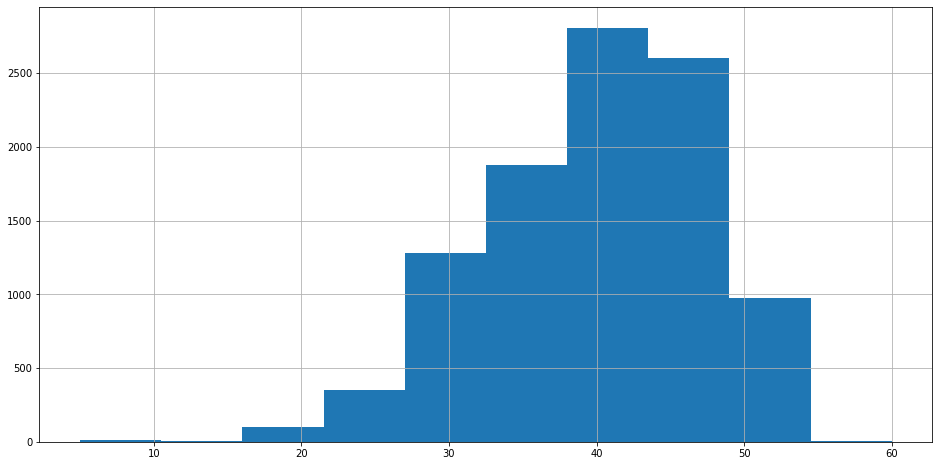

In [110]:
news['headline_text'].str.len().hist()

#### Now, we will move on to data exploration at a word-level. Let’s plot the number of words appearing in each news headline.

<AxesSubplot:>

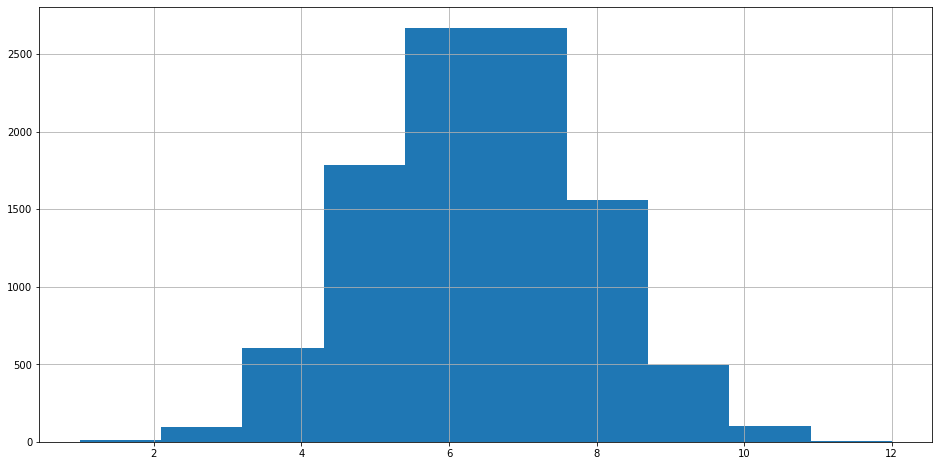

In [111]:
news['headline_text'].str.split().map(lambda x: len(x)).hist()

#### Up next, let’s check the average word length in each sentence.

<AxesSubplot:>

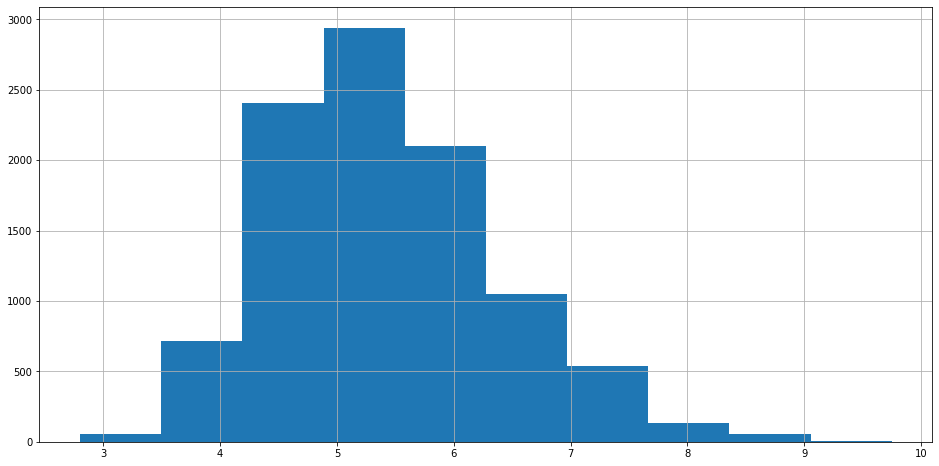

In [112]:
news['headline_text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

#### Loading stopwords list

In [113]:
#import nltk
#nltk.download('stopwords')
stop = set(nltk.corpus.stopwords.words('english'))

#### Now, we’ll  create the corpus.

In [114]:
corpus=[]
new = news['headline_text'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

#### Plot top stopwords

<BarContainer object of 10 artists>

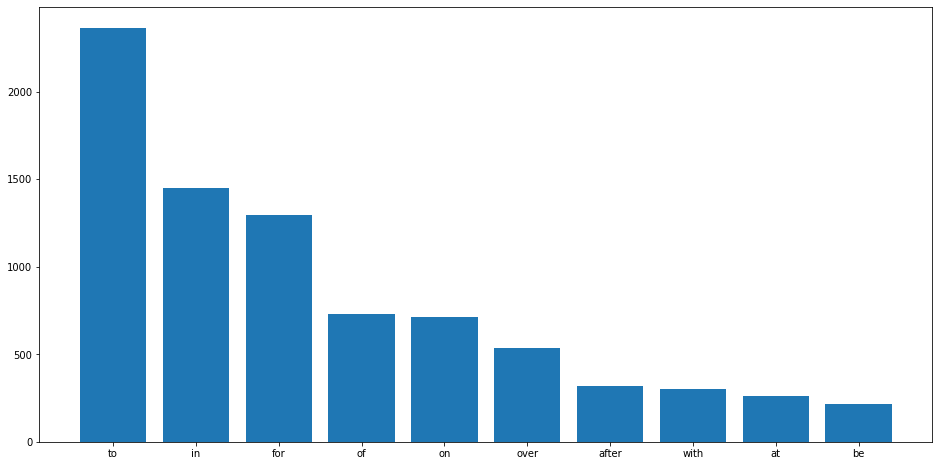

In [115]:
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y = zip(*top)
plt.bar(x,y)

#### We will use the counter function from the collections library to count and store the occurrences of each word in a list of tuples.

<AxesSubplot:>

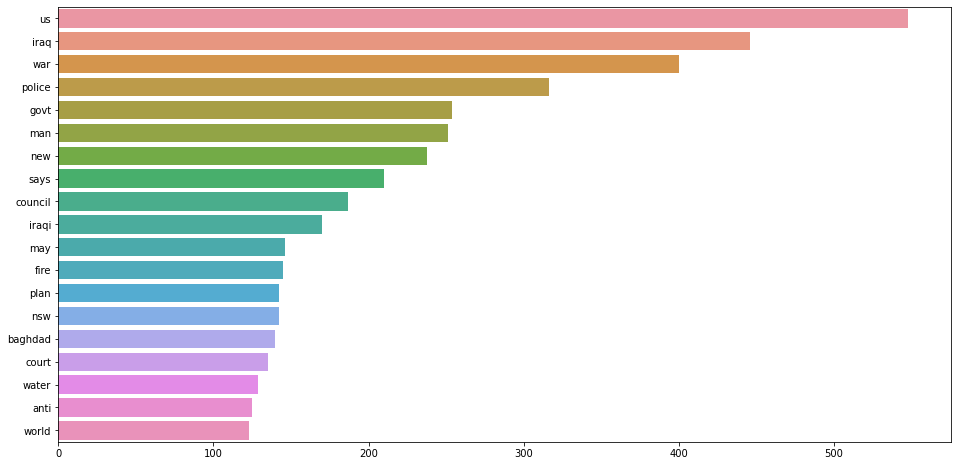

In [116]:
counter = Counter(corpus)
most = counter.most_common()

x, y = [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

#### Ngram exploration  

Ngrams are simply contiguous sequences of n words.   

Looking at most frequent n-grams can give you a better understanding of the context in which the word was used.  

In [117]:
from nltk.util import ngrams
list(ngrams(['I' ,'went','to','the','river','bank'],2))

[('I', 'went'),
 ('went', 'to'),
 ('to', 'the'),
 ('the', 'river'),
 ('river', 'bank')]

#### To build a representation of our vocabulary we will use Countvectorizer.

In [118]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<AxesSubplot:>

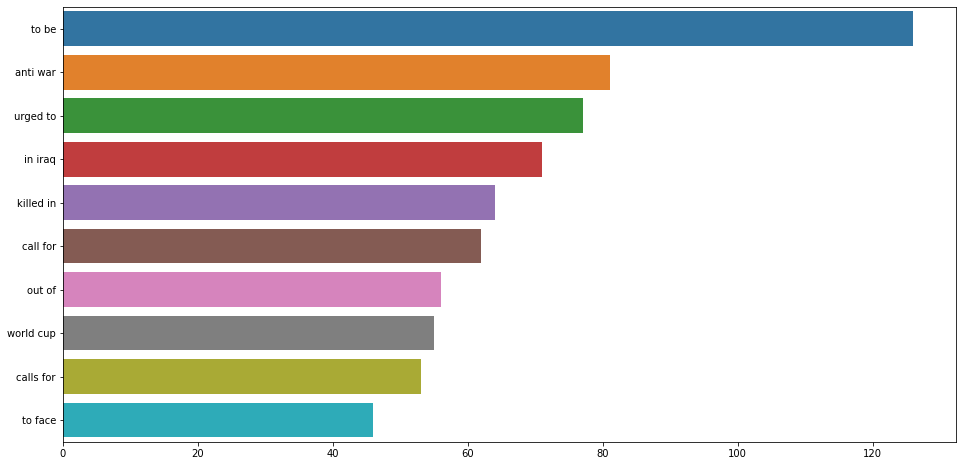

In [119]:
top_n_bigrams=get_top_ngram(news['headline_text'],2)[:10]
x,y = map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

#### How about trigrams?

<AxesSubplot:>

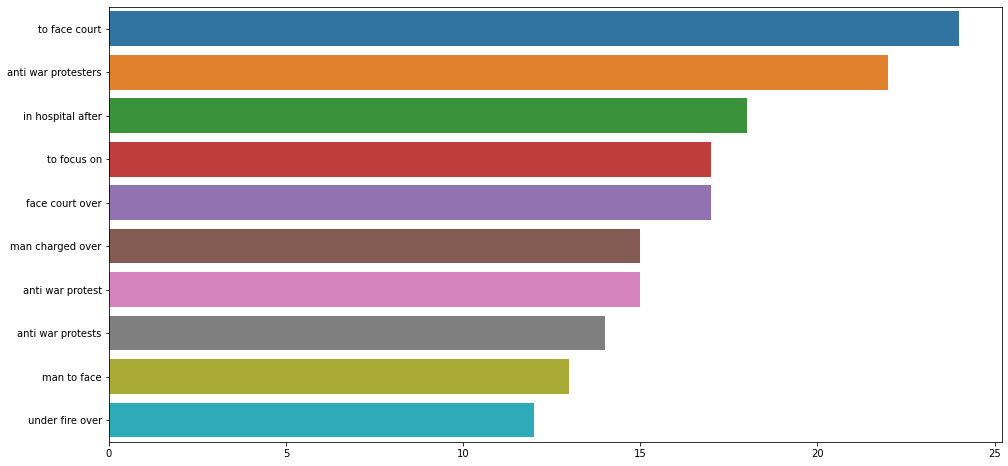

In [120]:
top_tri_grams=get_top_ngram(news['headline_text'],n=3)
x,y = map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

#### Topic Modeling exploration with pyLDAvis

In [121]:
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_news(df):
    corpus = []
    stem = nltk.stem.PorterStemmer()
    lem = nltk.stem.WordNetLemmatizer()
    for news in df['headline_text']:
        words=[w for w in nltk.tokenize.word_tokenize(news) if (w not in stop)]
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus

corpus = preprocess_news(news)

[nltk_data] Downloading package punkt to /home/renato/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/renato/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Now, let’s create the bag of words model using gensim

In [122]:
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

#### Create the LDA model:

In [123]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 4, id2word = dic, passes = 10, workers = 2,  per_word_topics=True)
lda_model.show_topics()

[(0,
  '0.006*"win" + 0.006*"cup" + 0.006*"council" + 0.005*"open" + 0.005*"new" + 0.005*"baghdad" + 0.004*"england" + 0.004*"world" + 0.004*"match" + 0.004*"clash"'),
 (1,
  '0.018*"war" + 0.009*"iraq" + 0.008*"anti" + 0.006*"govt" + 0.006*"two" + 0.006*"say" + 0.005*"claim" + 0.005*"protest" + 0.004*"win" + 0.004*"may"'),
 (2,
  '0.016*"iraq" + 0.010*"plan" + 0.009*"man" + 0.008*"iraqi" + 0.007*"police" + 0.007*"war" + 0.006*"say" + 0.006*"crash" + 0.006*"death" + 0.005*"fire"'),
 (3,
  '0.009*"new" + 0.007*"police" + 0.005*"baghdad" + 0.005*"air" + 0.005*"troop" + 0.005*"world" + 0.005*"man" + 0.005*"water" + 0.005*"govt" + 0.005*"woman"')]

#### What is the Dominant topic and its percentage contribution in each document

In [124]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), 
                                                                  round(prop_topic,4), 
                                                                  topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(lda_model, bow_corpus, news['headline_text'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.8707,"iraq, plan, man, iraqi, police, war, say, cras...",aba decides against community broadcasting lic...
1,1,1.0,0.8849,"war, iraq, anti, govt, two, say, claim, protes...",act fire witnesses must be aware of defamation
2,2,2.0,0.5566,"iraq, plan, man, iraqi, police, war, say, cras...",a g calls for infrastructure protection summit
3,3,3.0,0.4921,"new, police, baghdad, air, troop, world, man, ...",air nz staff in aust strike for pay rise
4,4,0.0,0.6082,"win, cup, council, open, new, baghdad, england...",air nz strike to affect australian travellers
5,5,1.0,0.8716,"war, iraq, anti, govt, two, say, claim, protes...",ambitious olsson wins triple jump
6,6,0.0,0.4994,"win, cup, council, open, new, baghdad, england...",antic delighted with record breaking barca
7,7,0.0,0.7534,"win, cup, council, open, new, baghdad, england...",aussie qualifier stosur wastes four memphis match
8,8,2.0,0.8671,"iraq, plan, man, iraqi, police, war, say, cras...",aust addresses un security council over iraq
9,9,1.0,0.5988,"war, iraq, anti, govt, two, say, claim, protes...",australia is locked into war timetable opp


#### Frequency Distribution of Word Counts in Documents

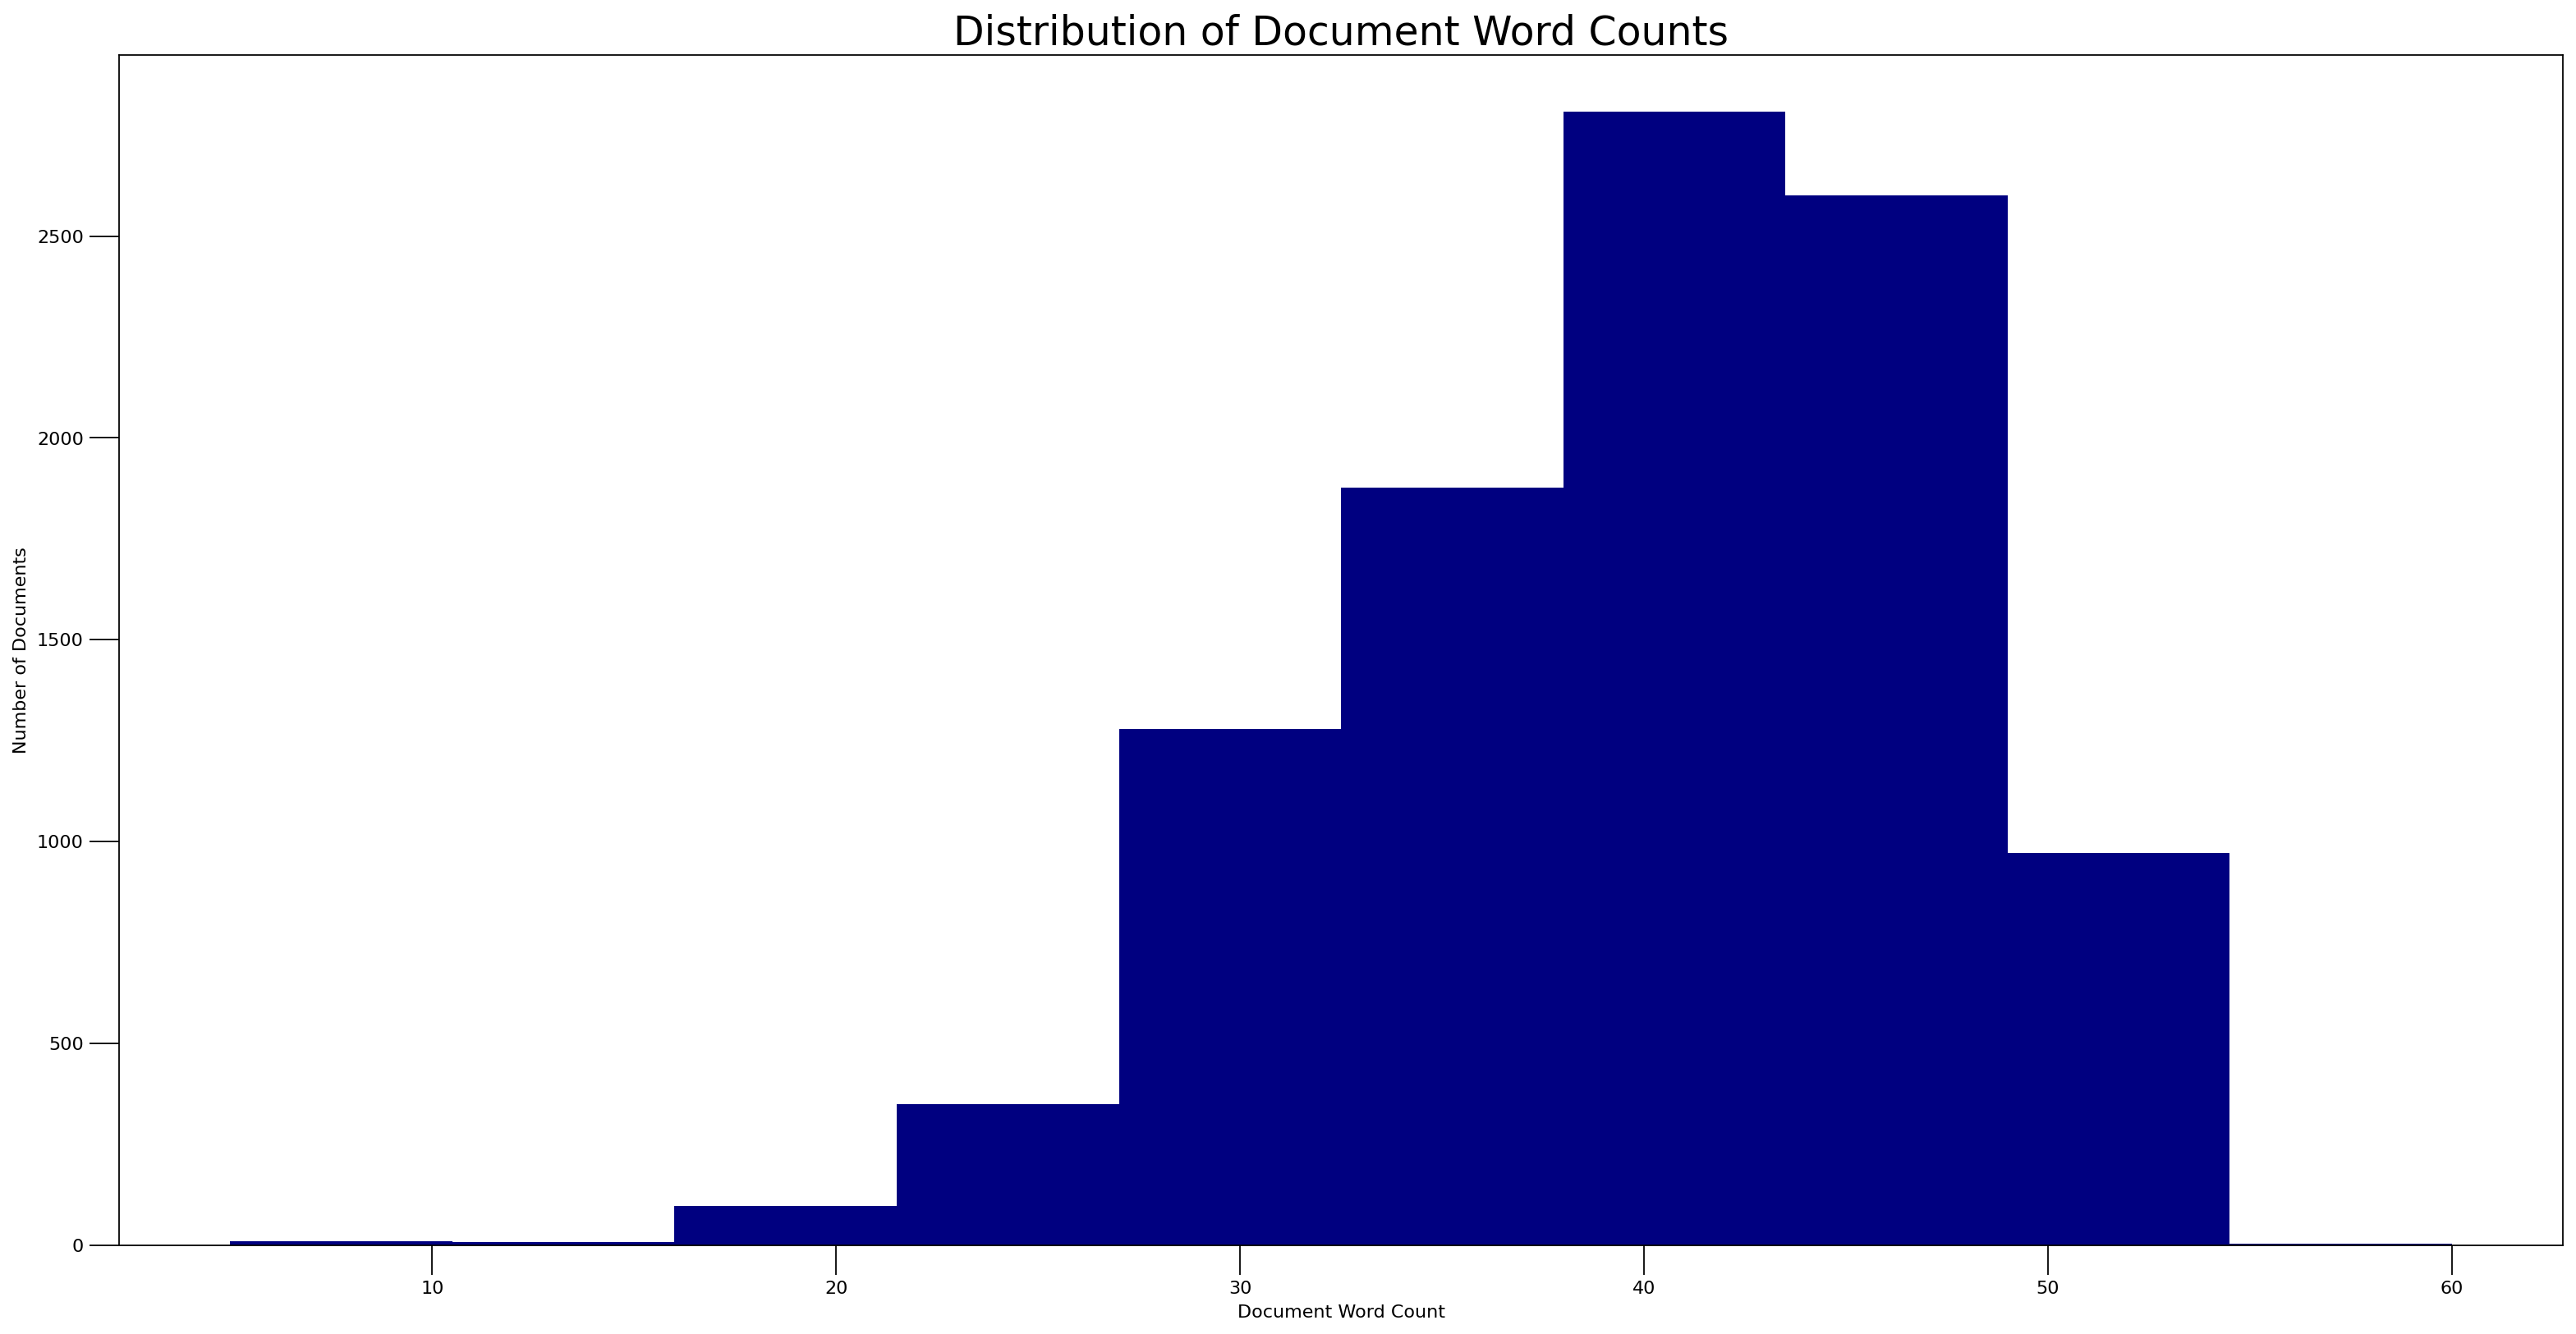

In [125]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(24,12), dpi=160)
plt.hist(doc_lens, color='navy') #, bins = 100)
#plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
#plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
#plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
#plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
#plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(ylabel='Number of Documents', xlabel='Document Word Count',) # xlim=(0, 100),)
plt.tick_params(size=16)
#plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

#### By Topic

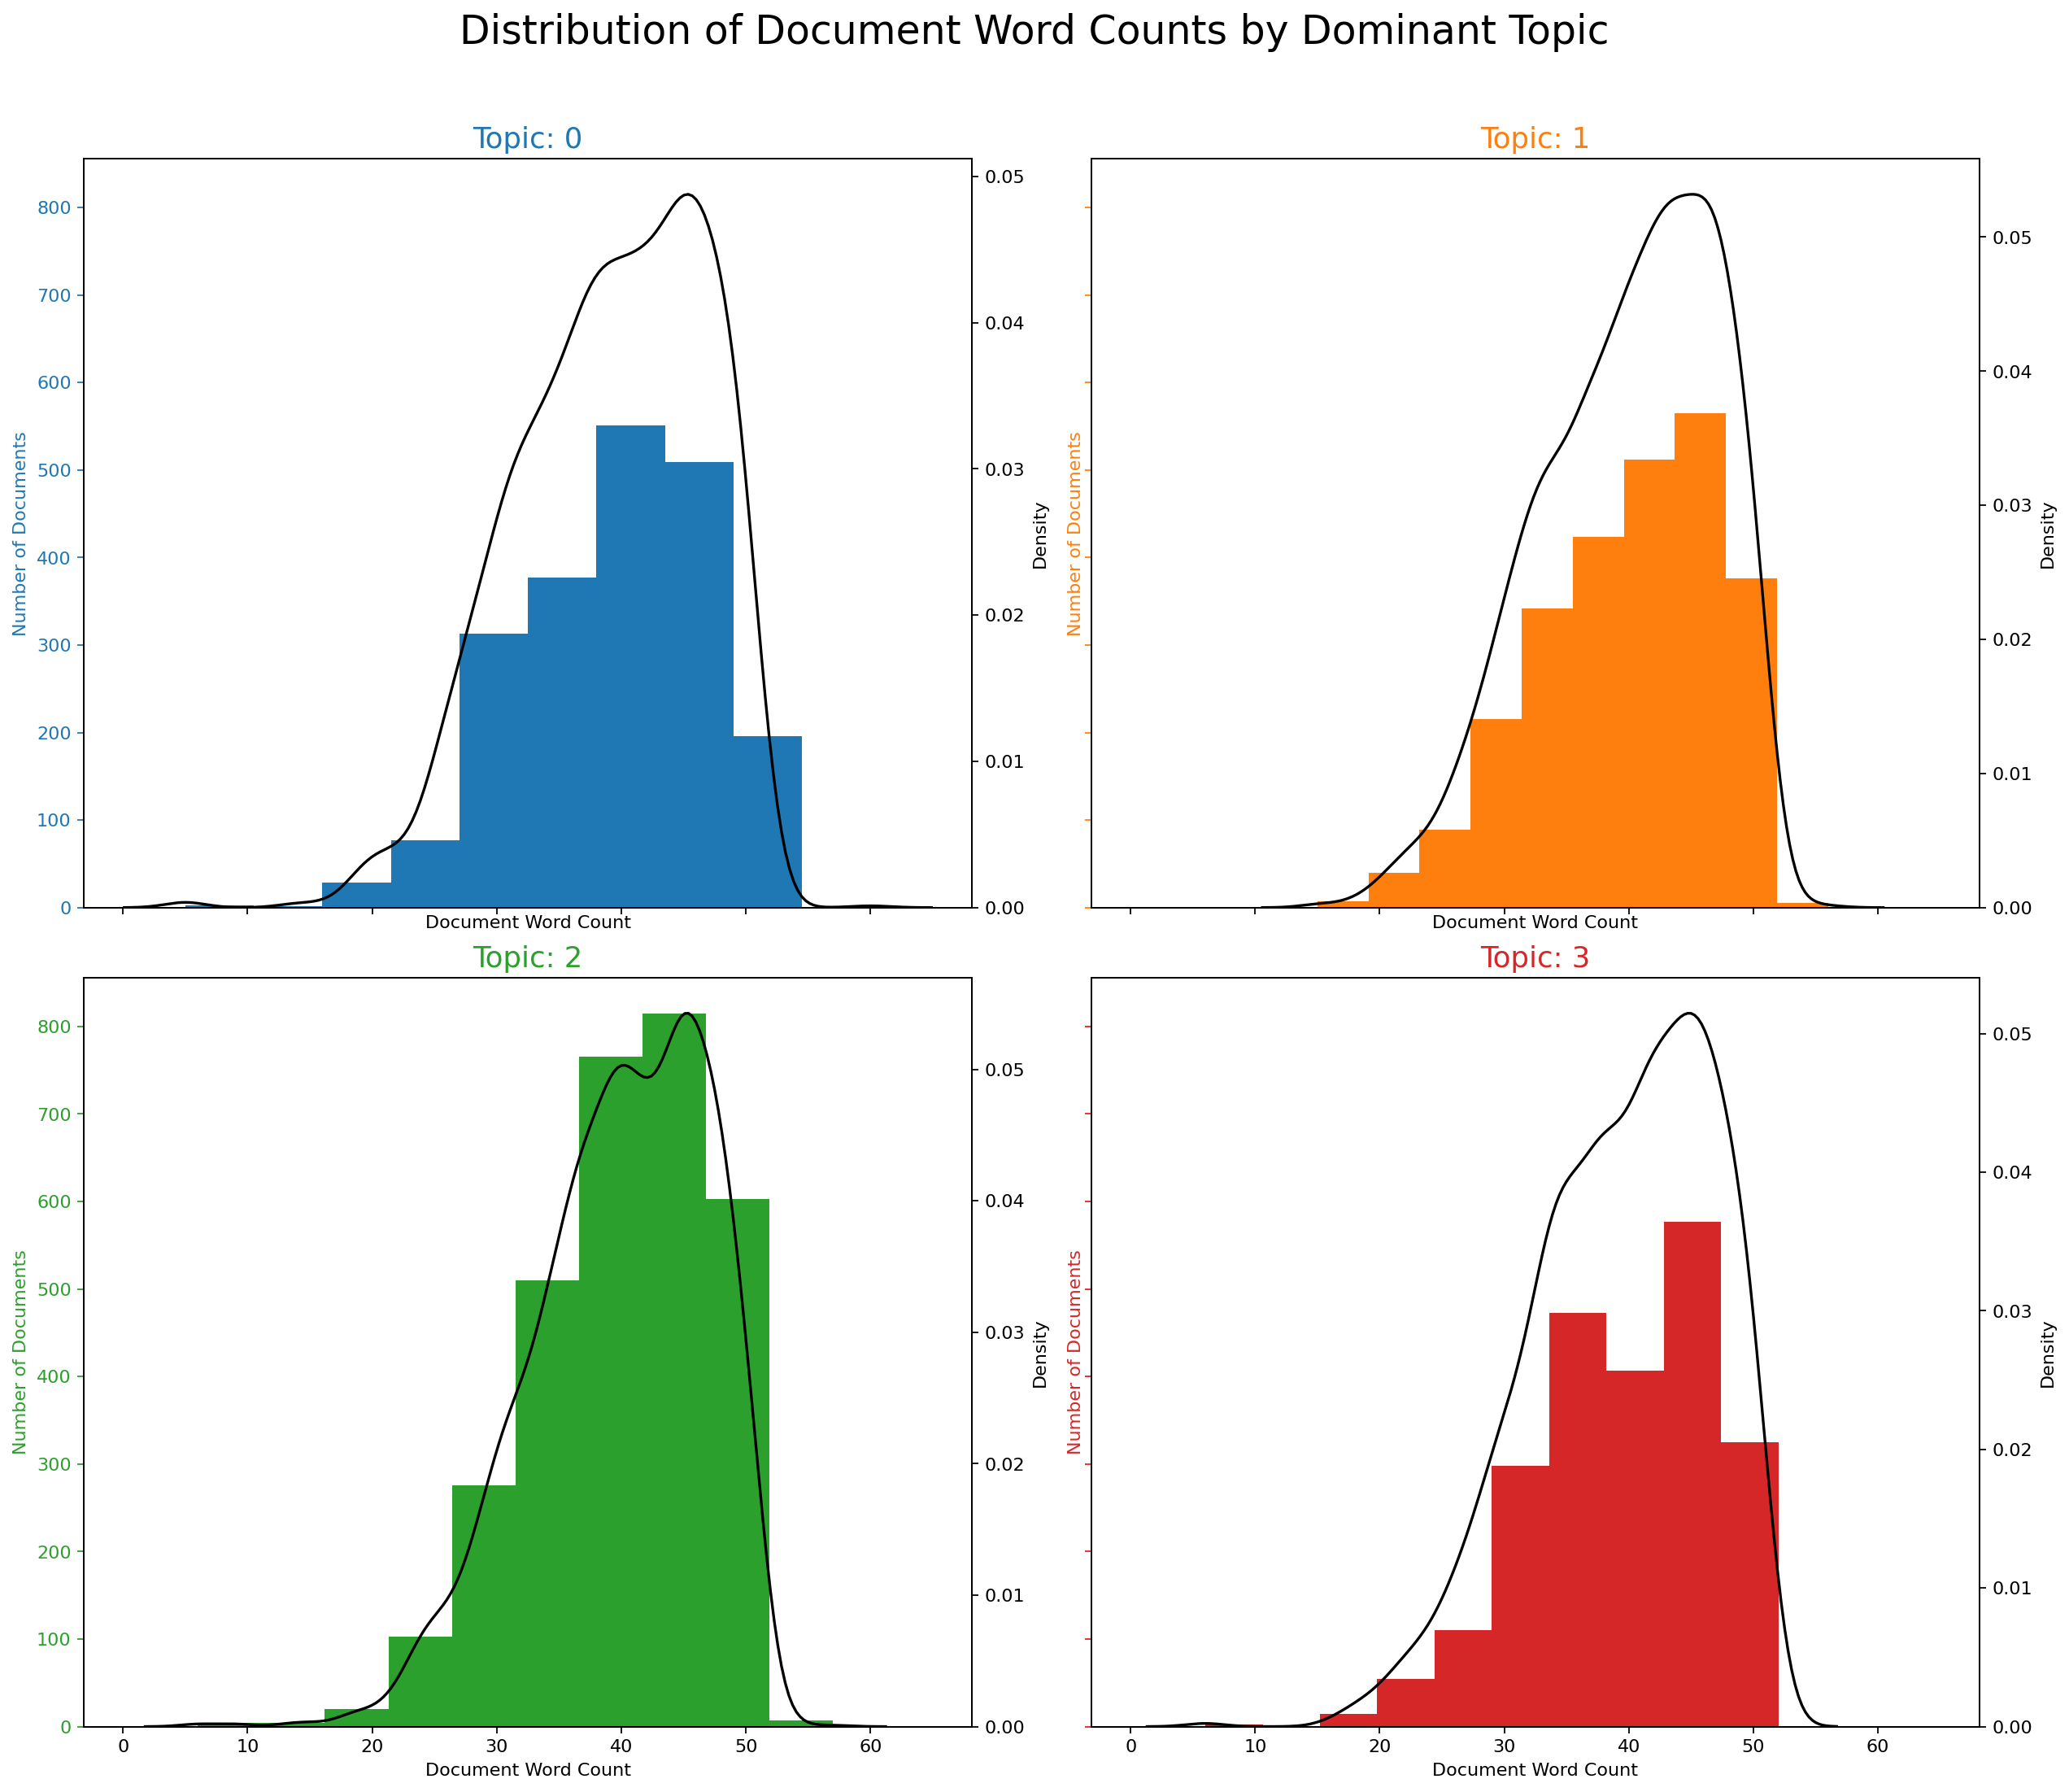

In [126]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, color=cols[i]) #, bins = 1000)
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlabel='Document Word Count') #xlim=(0, 1000),
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
#plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

#### Word Clouds of Top N Keywords in Each Topic

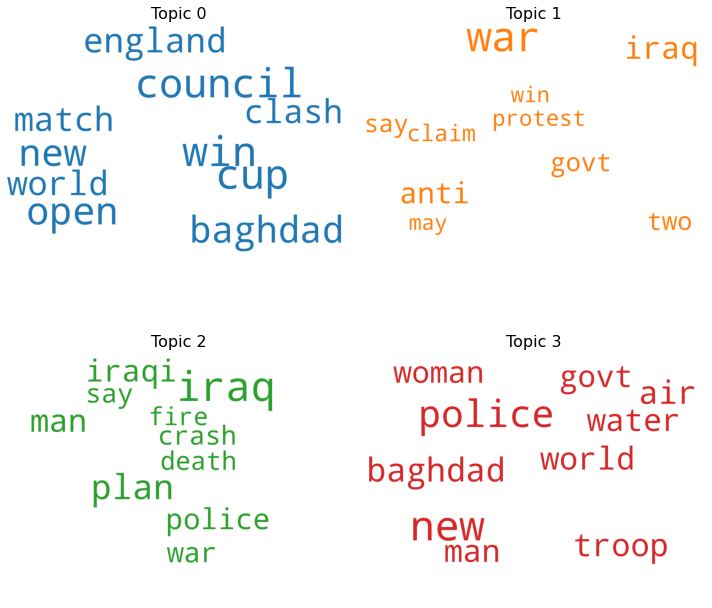

In [127]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Word Counts of Topic Keywords

/tmp/ipykernel_172351/4070907284.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_172351/4070907284.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_172351/4070907284.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_172351/4070907284.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


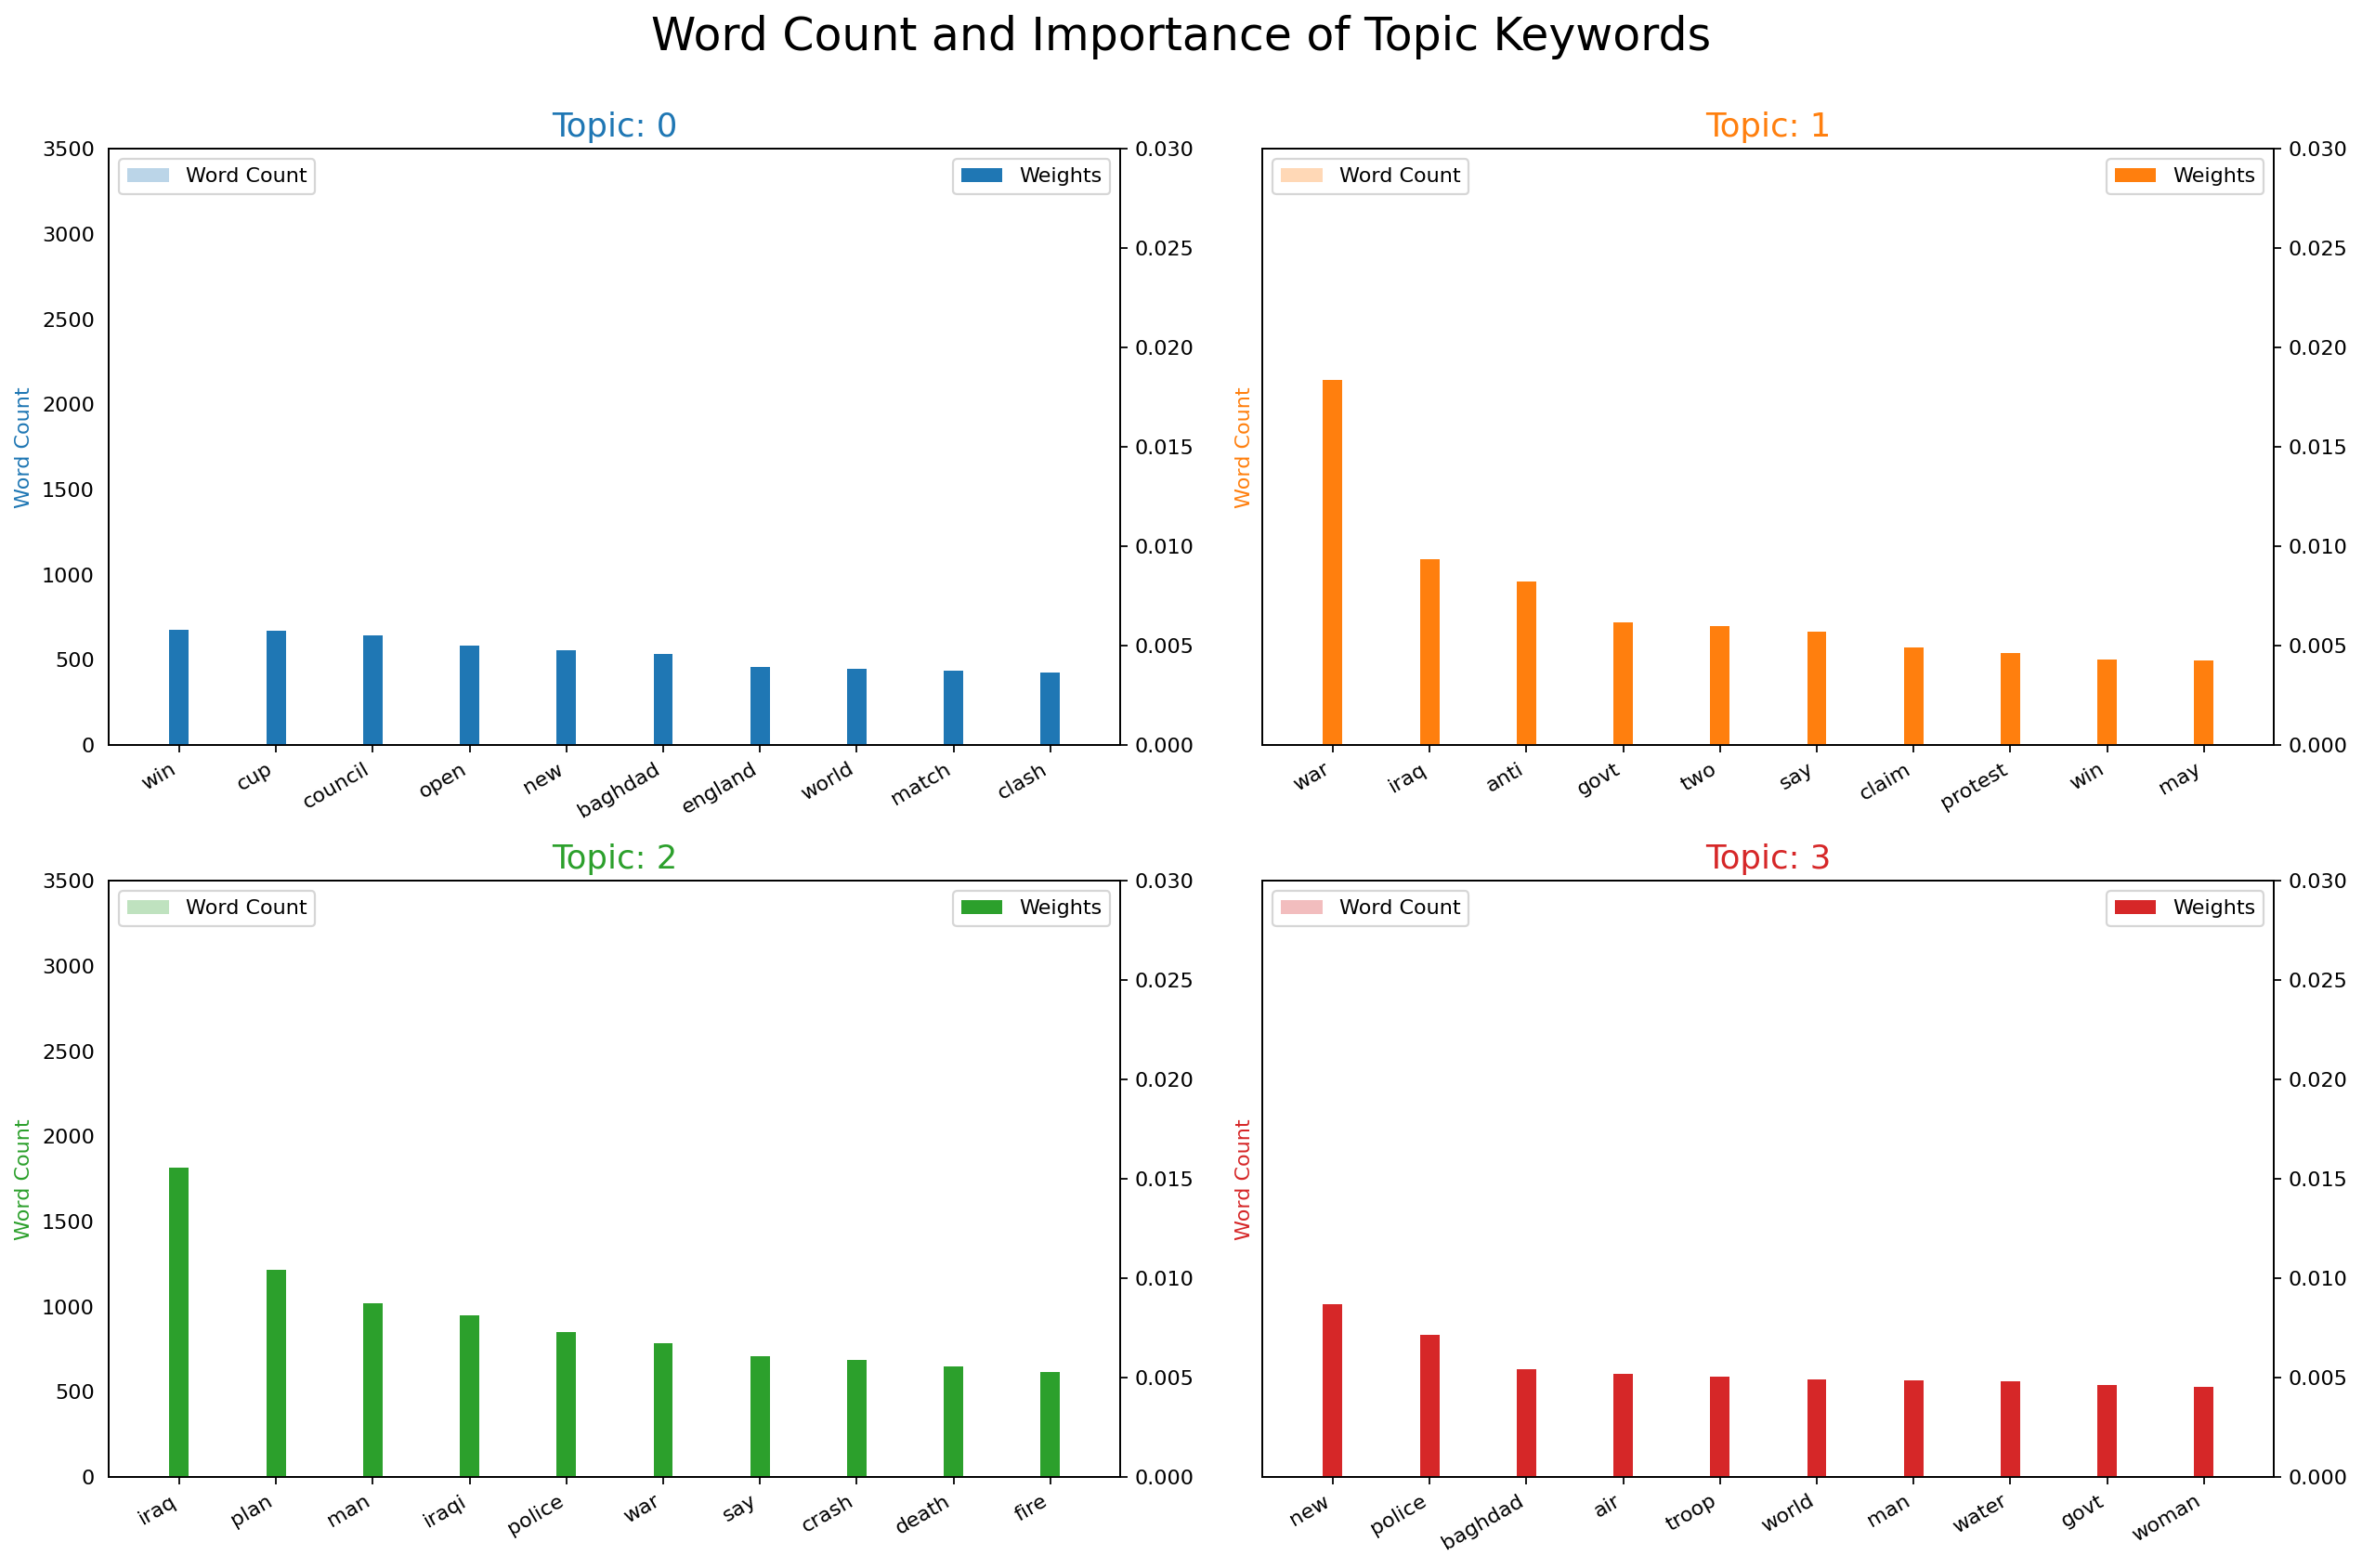

In [128]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in news['headline_text'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

#### Sentence Chart Colored by Topic

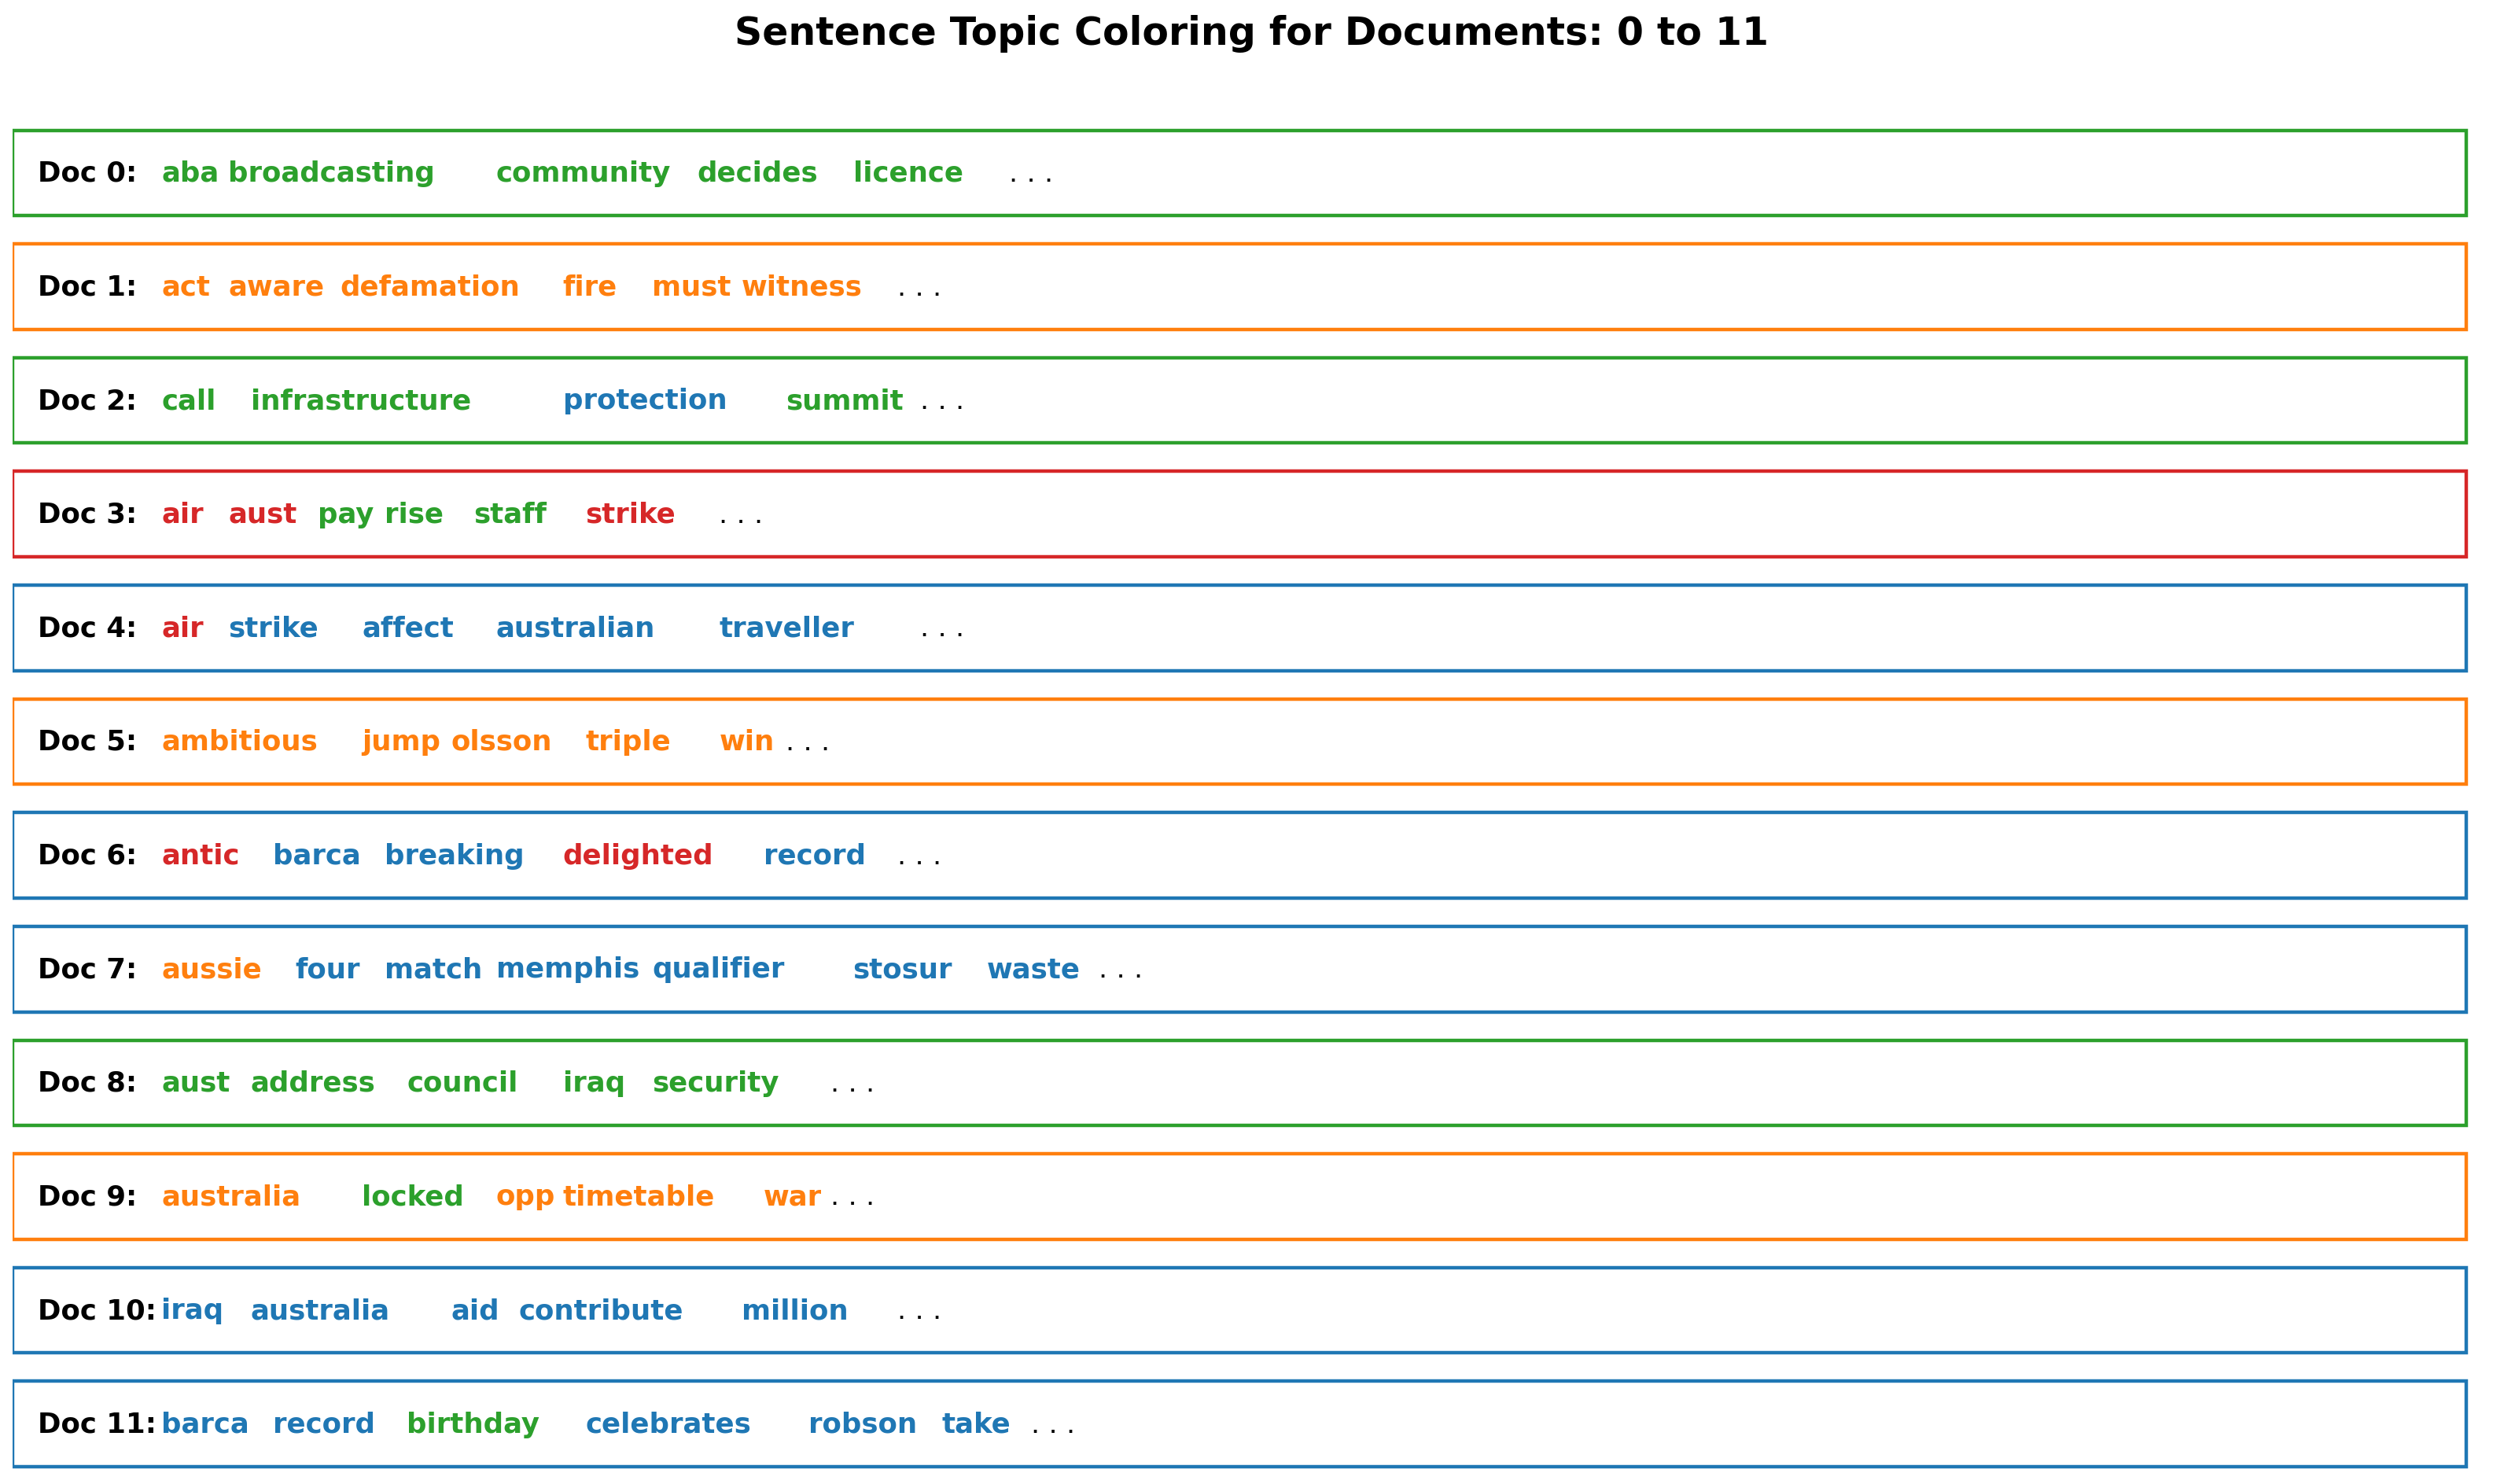

In [129]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model, corpus, start=0, end=13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 
                    0.5, 
                    "Doc " + str(i-1) + ": ", 
                    verticalalignment='center',
                    fontsize=16, 
                    color='black',
                    transform=ax.transAxes, 
                    fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color = mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment = 'left',
                            verticalalignment = 'center',
                            fontsize = 16, color = mycolors[topics],
                            transform = ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
                    
            ax.text(word_pos, 0.5, 
                    '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart(lda_model, bow_corpus)    

#### What are the most discussed topics in the documents?

In [130]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=bow_corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0, inplace=True)

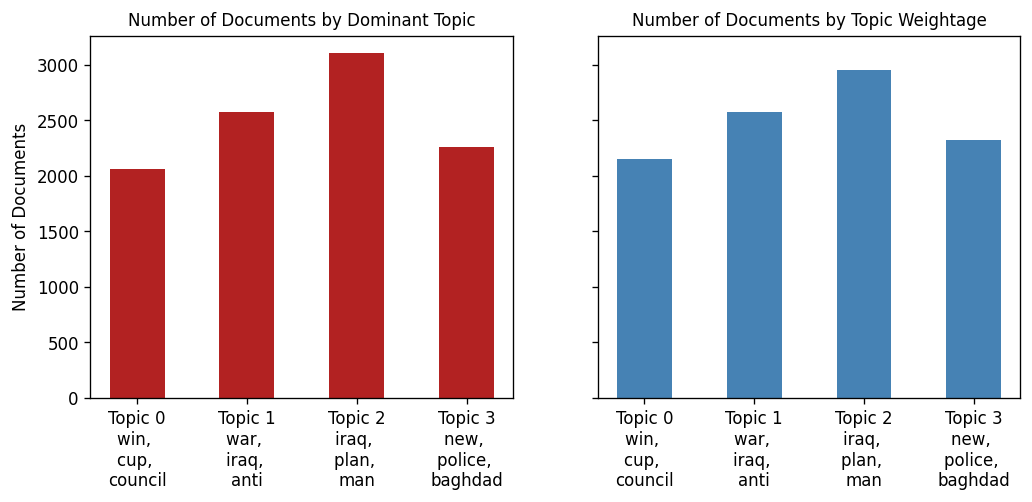

In [131]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
# ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

#### t-SNE Clustering Chart

In [132]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[bow_corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/home/renato/Documentos/envs/default/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9972 samples in 0.005s...
[t-SNE] Computed neighbors for 9972 samples in 0.152s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9972
[t-SNE] Computed conditional probabilities for sample 2000 / 9972
[t-SNE] Computed conditional probabilities for sample 3000 / 9972
[t-SNE] Computed conditional probabilities for sample 4000 / 9972
[t-SNE] Computed conditional probabilities for sample 5000 / 9972
[t-SNE] Computed conditional probabilities for sample 6000 / 9972
[t-SNE] Computed conditional probabilities for sample 7000 / 9972
[t-SNE] Computed conditional probabilities for sample 8000 / 9972
[t-SNE] Computed conditional probabilities for sample 9000 / 9972
[t-SNE] Computed conditional probabilities for sample 9972 / 9972
[t-SNE] Mean sigma: 0.000967


/home/renato/Documentos/envs/default/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.084084
[t-SNE] KL divergence after 1000 iterations: 0.731008


Loading BokehJS ...

#### Visualizes the results of LDA interactively

In [133]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
vis

/home/renato/Documentos/envs/default/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.109368 -0.023172       1        1  29.525771
1     -0.052913 -0.119558       2        1  25.902905
3     -0.021588  0.170858       3        1  23.118822
0      0.183869 -0.028128       4        1  21.452503, topic_info=         Term        Freq       Total Category  logprob  loglift
60       plan  157.000000  157.000000  Default  30.0000  30.0000
49        war  383.000000  383.000000  Default  29.0000  29.0000
588      anti  109.000000  109.000000  Default  28.0000  28.0000
1337      two   80.000000   80.000000  Default  27.0000  27.0000
228     crash   91.000000   91.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
149   welcome   25.647143   58.615466   Topic4  -6.0559   0.7128
88       lead   26.493851   74.788176   Topic4  -6.0234   0.5016
49        war   32.541762  383.645277   Topic4  -5.8178  -0.9279
56       take   27.593890  103.023740   Topic4  -5.9827   0.2220
627    killed   26.469105   95.902268   Topic4  -6.0243   0.2520

[294 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1759      3  0.926216   across
5         1  0.164467      act
5         2  0.575636      act
5         3  0.263148      act
1951      4  0.944525  african
...     ...       ...      ...
243       2  0.170837     work
243       3  0.811475     work
488       2  0.107374    world
488       3  0.518976    world
488       4  0.375810    world

[464 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

#### Wordcloud

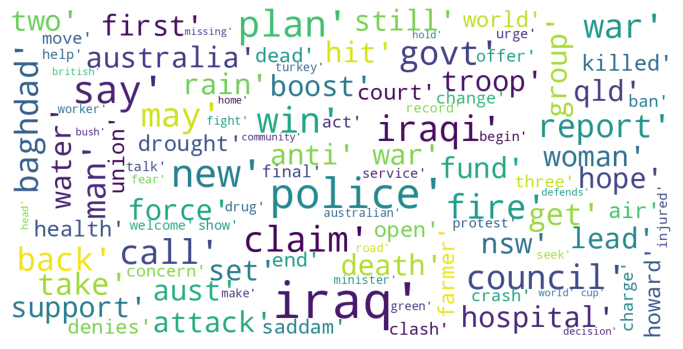

In [134]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

#### Sentiment analysis

In [135]:
from textblob import TextBlob
TextBlob('100 people killed in Iraq').sentiment

Sentiment(polarity=-0.2, subjectivity=0.0)

<AxesSubplot:>

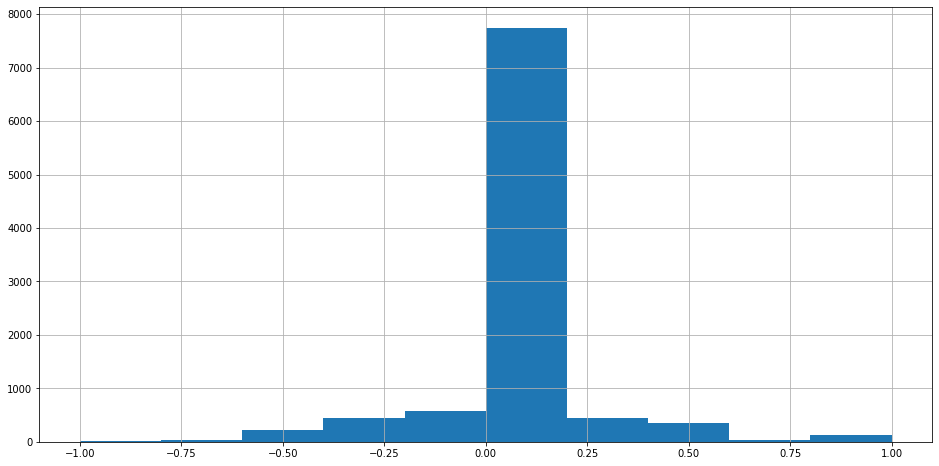

In [136]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

news['polarity_score'] = news['headline_text'].apply(lambda x : polarity(x))
news['polarity_score'].hist()

#### Let’s dig a bit deeper by classifying the news as negative, positive and neutral based on the scores.

<BarContainer object of 3 artists>

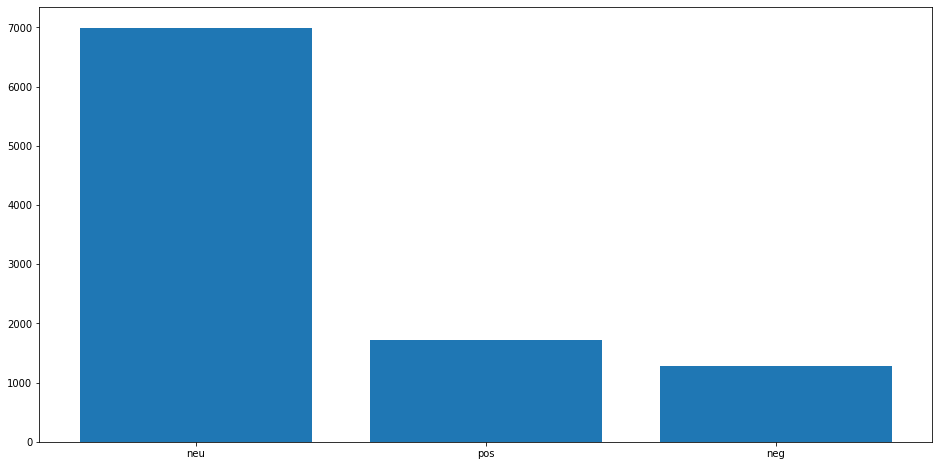

In [137]:
def sentiment(x):
    if x < 0:
        return 'neg'
    elif x == 0:
        return 'neu'
    else:
        return 'pos'
    
news['polarity']=news['polarity_score'].map(lambda x: sentiment(x))
plt.bar(news.polarity.value_counts().index, news.polarity.value_counts())

In [138]:
news[news['polarity'] == 'pos']['headline_text'].head()

1     act fire witnesses must be aware of defamation
5                  ambitious olsson wins triple jump
6         antic delighted with record breaking barca
18        bryant leads lakers to double overtime win
26      commonwealth bank cuts fixed home loan rates
Name: headline_text, dtype: object

In [139]:
news[news['polarity'] == 'neg']['headline_text'].head()

7     aussie qualifier stosur wastes four memphis match
23               carews freak goal leaves roma in ruins
28     council chief executive fails to secure position
34                   dargo fire threat expected to rise
40        direct anger at govt not soldiers crean urges
Name: headline_text, dtype: object

#### Vader Sentiment Analysis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/renato/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<BarContainer object of 3 artists>

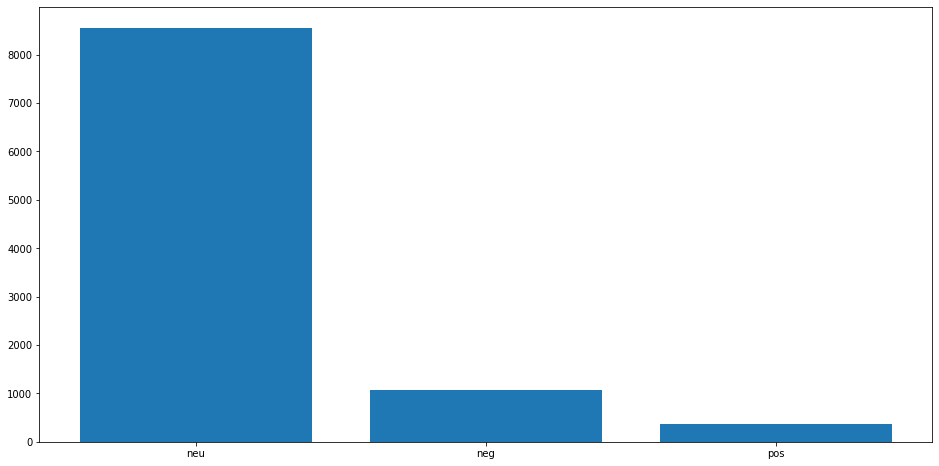

In [140]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

news['polarity']=news['headline_text'].map(lambda x: get_vader_score(x))
polarity=news['polarity'].replace({0:'neg',1:'neu',2:'pos'})

plt.bar(polarity.value_counts().index, polarity.value_counts())

#### Named Entity Recognition

In [141]:
#!python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm")

In [142]:
doc = nlp('India and Iran have agreed to boost the economic viability \
of the strategic Chabahar port through various measures, \
including larger subsidies to merchant shipping firms using the facility, \
people familiar with the development said on Thursday.')

[(x.text,x.label_) for x in doc.ents]

[('India', 'GPE'), ('Iran', 'GPE'), ('Thursday', 'DATE')]

In [143]:
from spacy import displacy

displacy.render(doc, style='ent')

In [144]:
def ner(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = news['headline_text'].apply(lambda x : ner(x))
ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()

#### Now, we can visualize the entity frequencies: 

<AxesSubplot:>

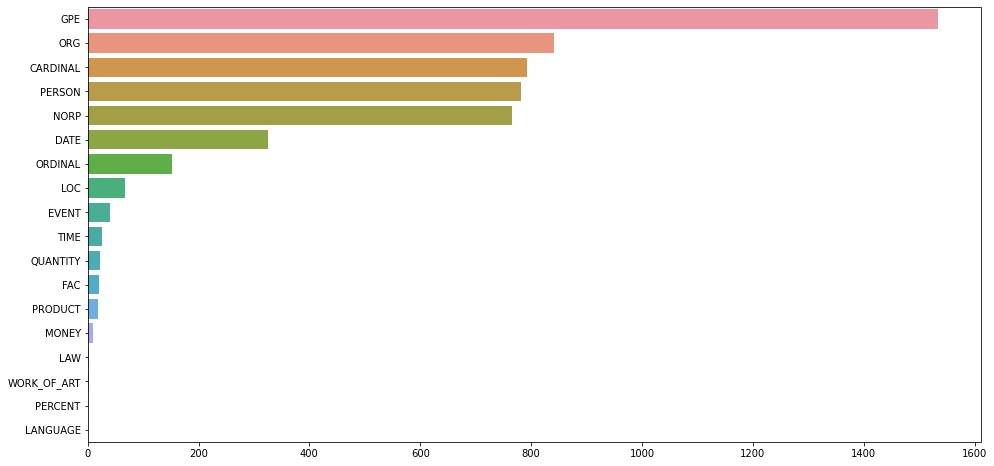

In [145]:
x,y = map(list,zip(*count))
sns.barplot(x=y, y=x)

#### We can also visualize the most common token per entity

<AxesSubplot:>

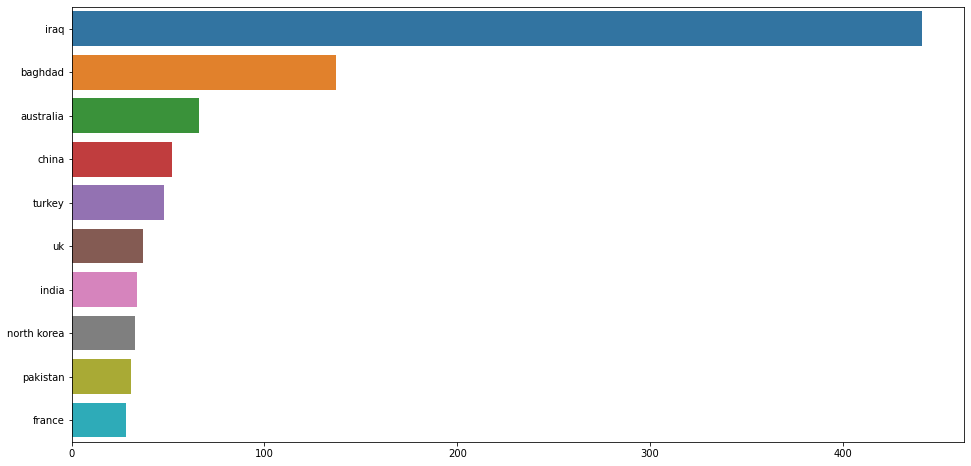

/home/renato/Documentos/envs/default/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/renato/Documentos/envs/default/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/renato/Documentos/envs/default/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/renato/Documentos/envs/default/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/renato/Documentos/envs/default

In [155]:
def ner(text, ent="GPE"):
    doc = nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe = news['headline_text'].apply(lambda x: ner(x))
gpe = [i for x in gpe for i in x]
counter = Counter(gpe)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(x=y,y=x)

#### Most common names on News headlines

<AxesSubplot:>

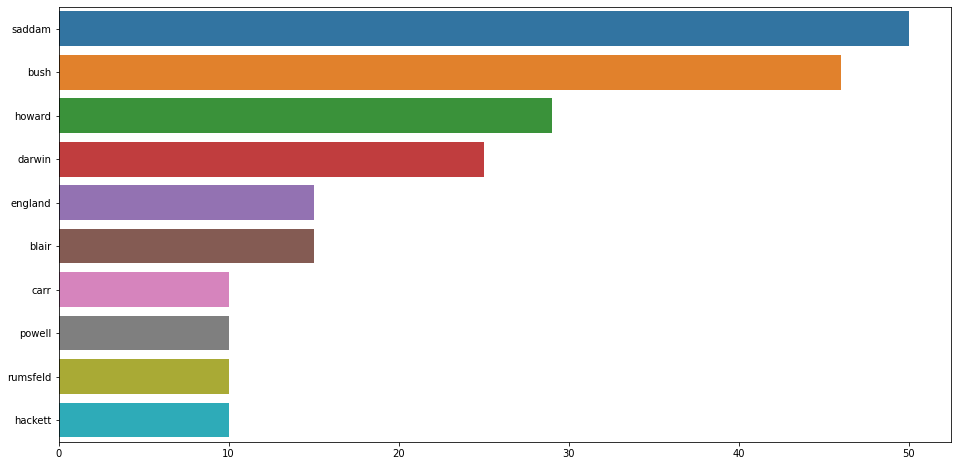

In [154]:
per = news['headline_text'].apply(lambda x: ner(x,"PERSON"))
per = [i for x in per for i in x]
counter = Counter(per)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(x=y,y=x)

#### Exploration through Parts of Speach Tagging in python

In [148]:
import nltk
sentence = "The greatest comeback stories in 2019"
tokens = nltk.tokenize.word_tokenize(sentence)
nltk.pos_tag(tokens)

[('The', 'DT'),
 ('greatest', 'JJS'),
 ('comeback', 'NN'),
 ('stories', 'NNS'),
 ('in', 'IN'),
 ('2019', 'CD')]

In [149]:
doc = nlp('The greatest comeback stories in 2019')
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

#### Now that we now what POS tagging is, let’s use it to explore our headlines dataset

<AxesSubplot:>

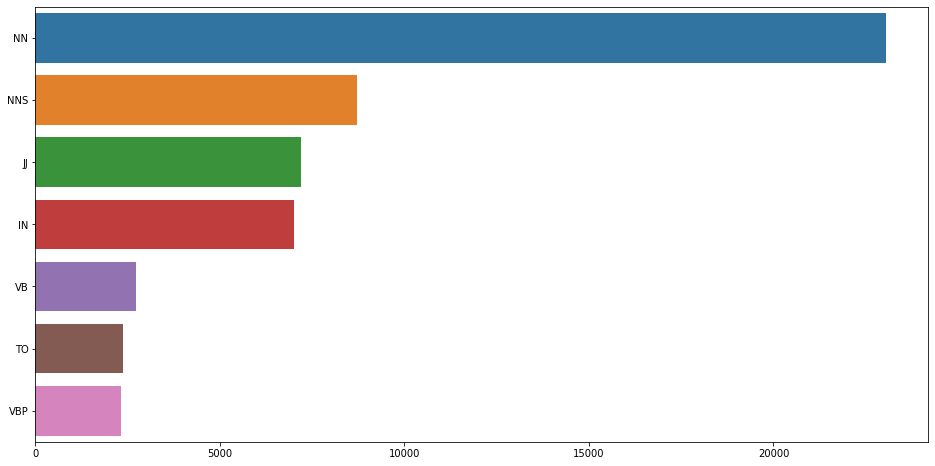

In [150]:
def pos(text):
    pos = nltk.pos_tag(nltk.tokenize.word_tokenize(text))
    pos = list(map(list,zip(*pos)))[1]
    return pos

tags = news['headline_text'].apply(lambda x : pos(x))
tags = [x for l in tags for x in l]
counter = Counter(tags)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

#### We can dig deeper into this by investigating which singular noun occur most commonly in news headlines

<AxesSubplot:>

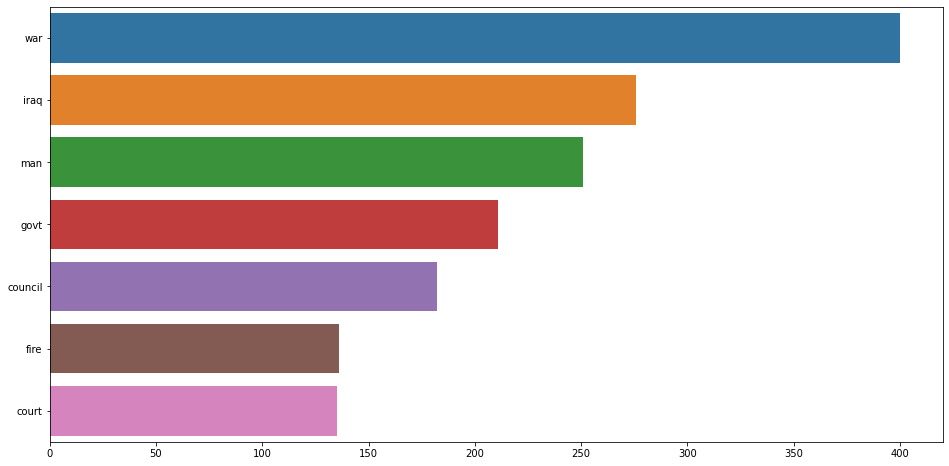

In [151]:
def get_adjs(text):
    adj = []
    pos = nltk.pos_tag(nltk.tokenize.word_tokenize(text))
    for word,tag in pos:
        if tag == 'NN':
            adj.append(word)
    return adj


words = news['headline_text'].apply(lambda x : get_adjs(x))
words = [x for l in words for x in l]
counter = Counter(words)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

#### Exploring through text complexity  

Readability index is a numeric value that indicates how difficult (or easy) it is to read and understand a text.  

<AxesSubplot:>

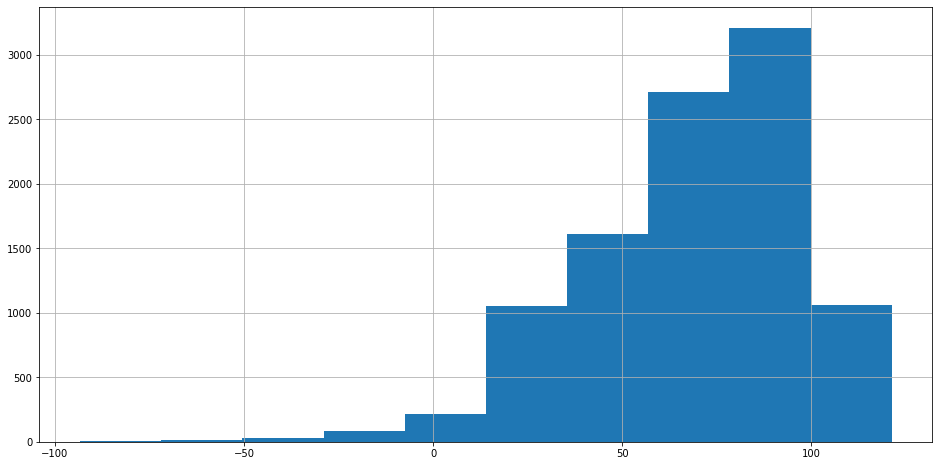

In [152]:
from textstat import flesch_reading_ease

news['headline_text'].apply(lambda x : flesch_reading_ease(x)).hist()

Almost all of the readability scores fall above 60. This means that an average 11-year-old student can read and understand the news headlines. Let’s check all news headlines that have a readability score below 5  

In [153]:
news['reading'] = news['headline_text'].apply(lambda x : flesch_reading_ease(x))
x = [i for i in range(len(news['reading'])) if news['reading'].iloc[i] < 5]
news.iloc[x]['headline_text'].head()

134    policewomen accusations feature at federal crime
150      report highlights container terminal potential
285       groups praise outgoing opposition agriculture
298            investigations underway into qantas skid
308      landholder contribution still under discussion
Name: headline_text, dtype: object